# Validate the trajectory and energy model by comparing the dynamic curves with other simulator and studies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os

In [2]:
casenames = os.listdir("exp1/")

C:\Users\User\AppData\Local\Temp\ipykernel_15272\1490158096.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,3, figsize=(12,3), sharex=True)


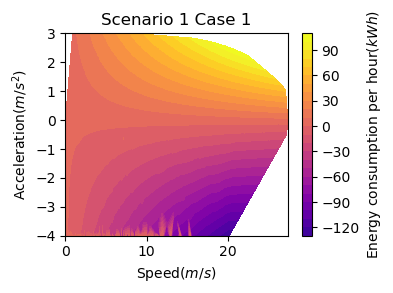

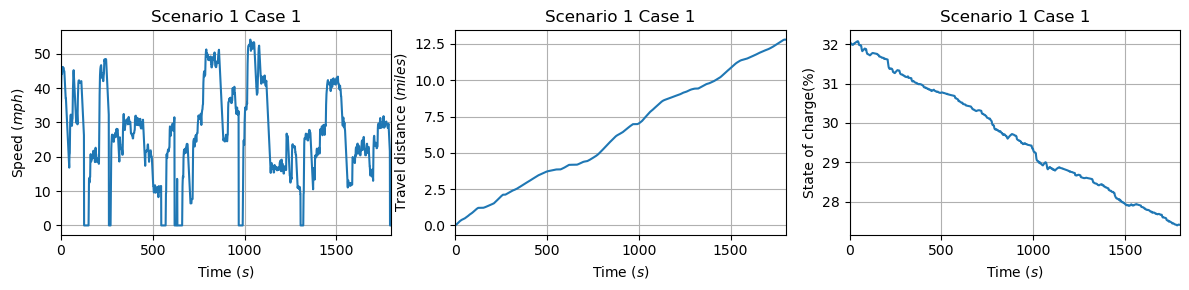

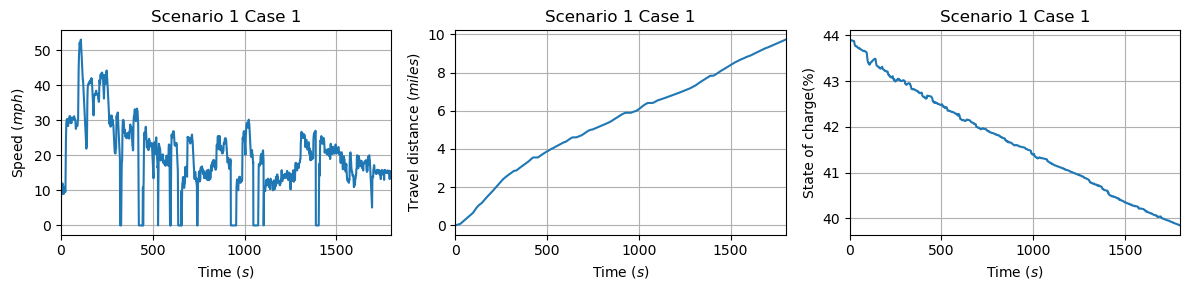

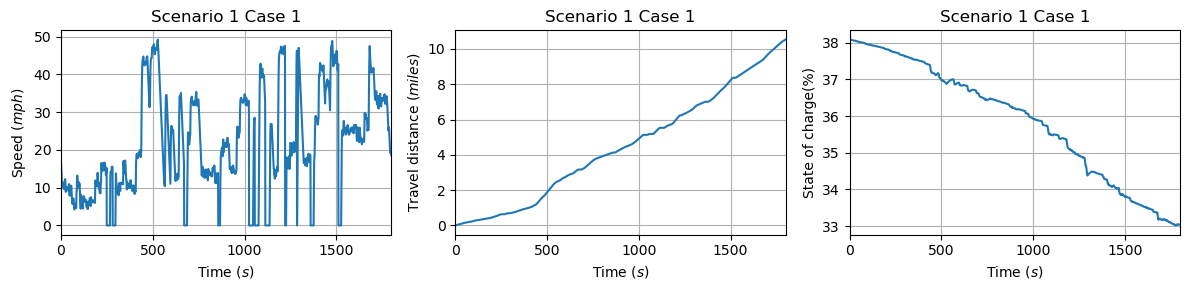

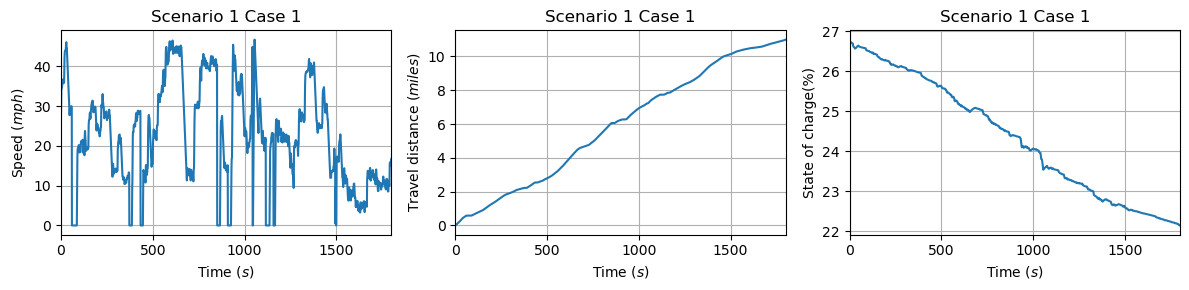

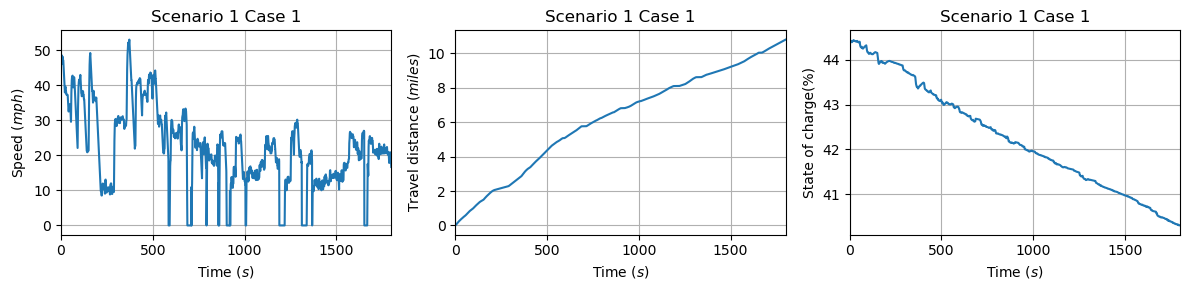

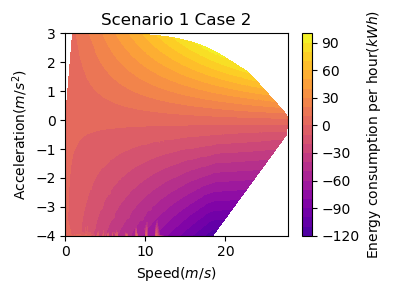

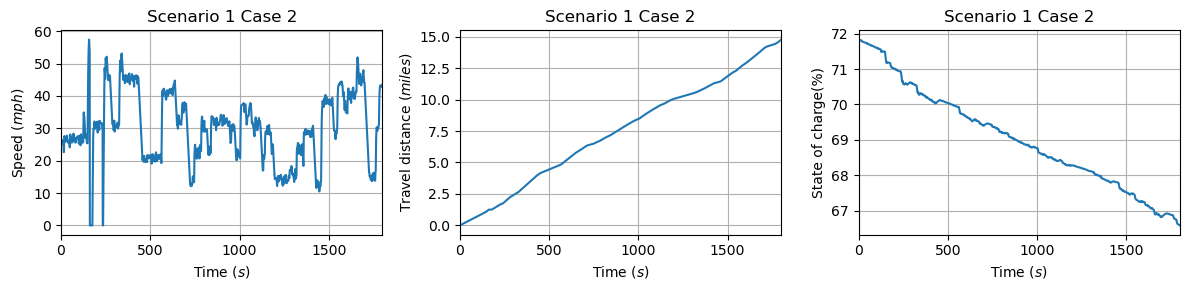

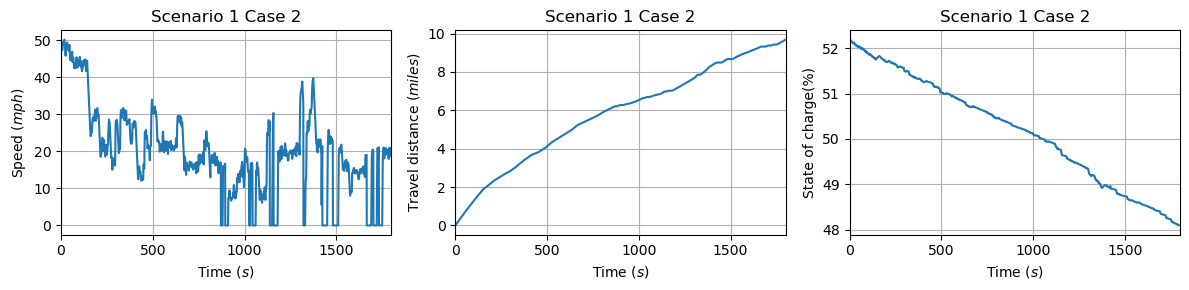

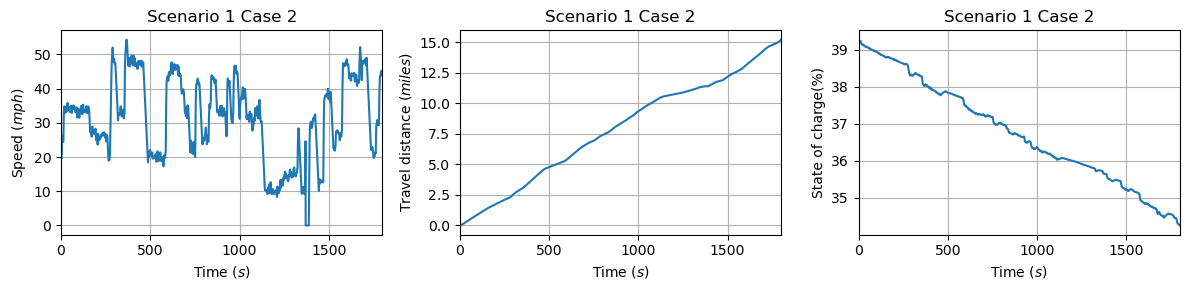

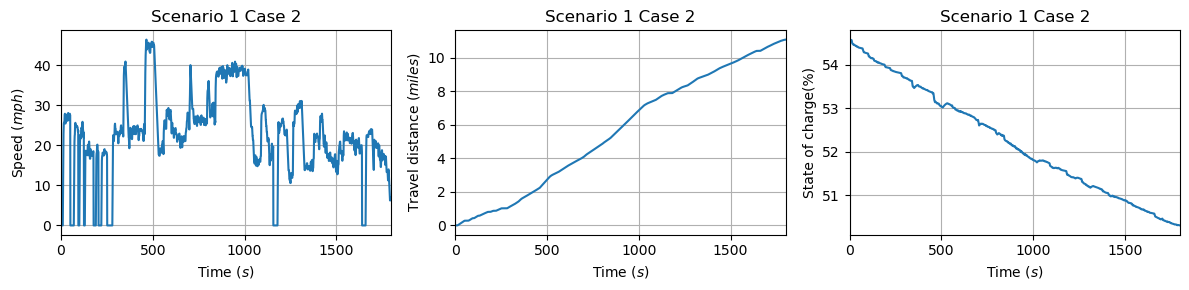

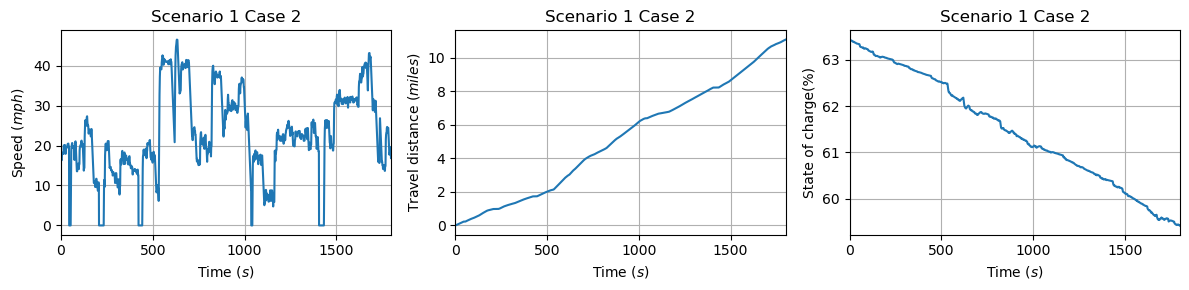

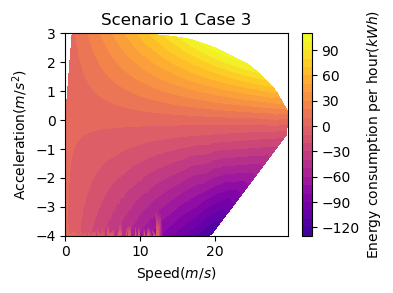

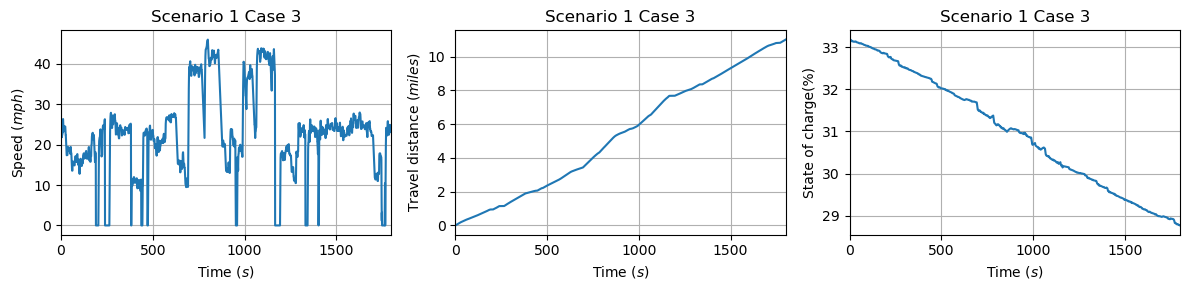

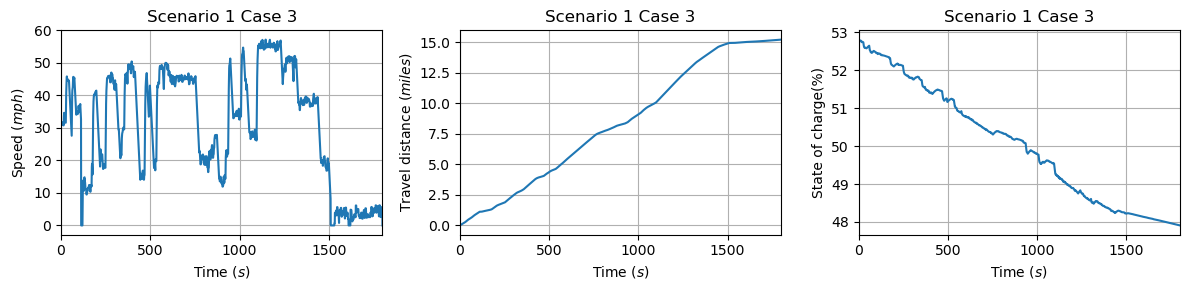

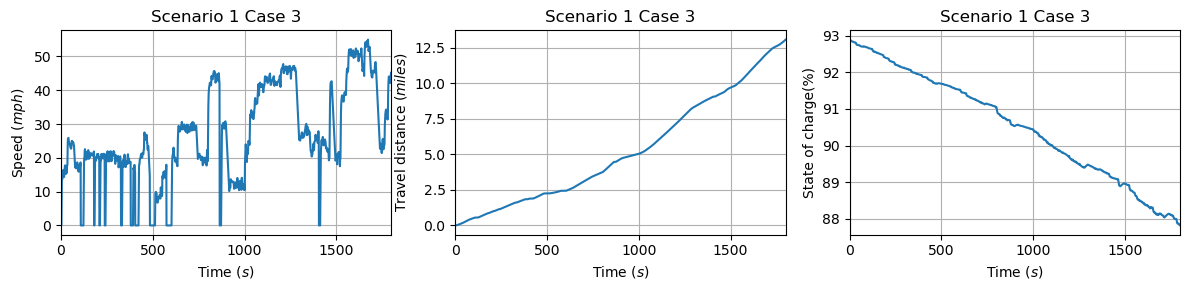

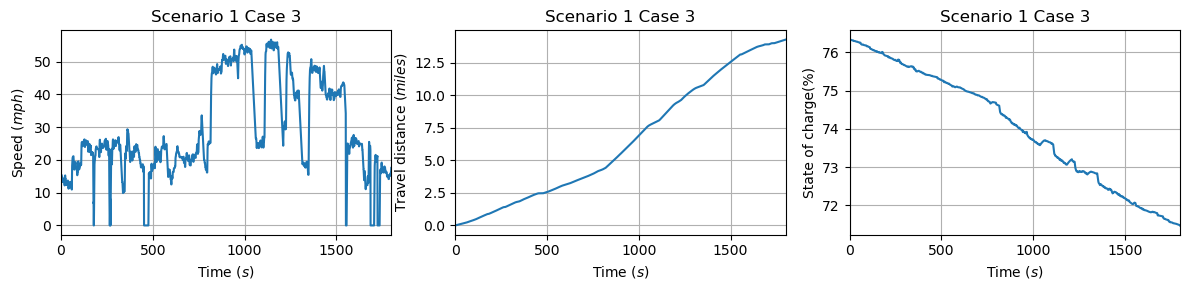

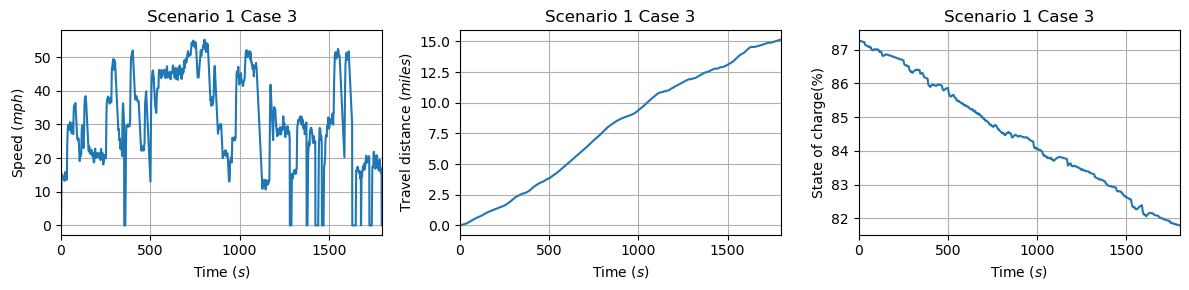

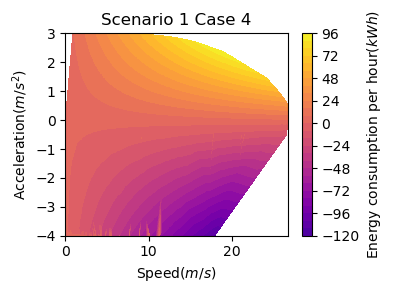

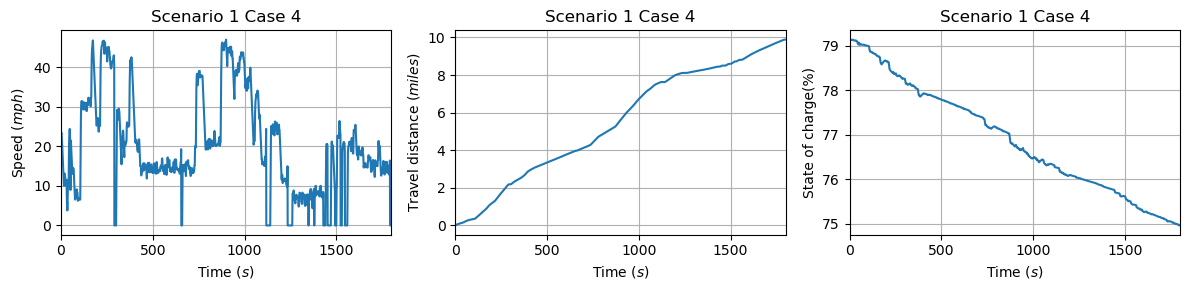

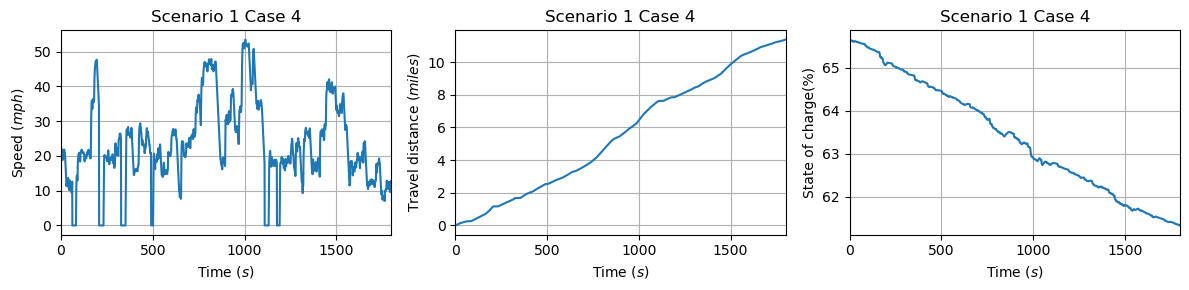

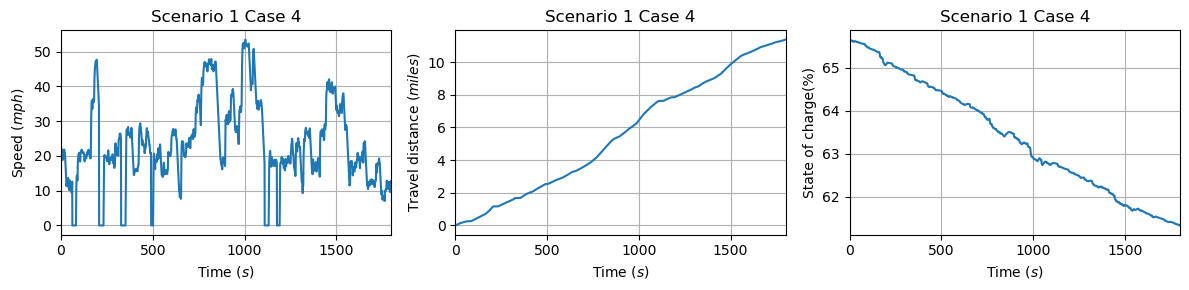

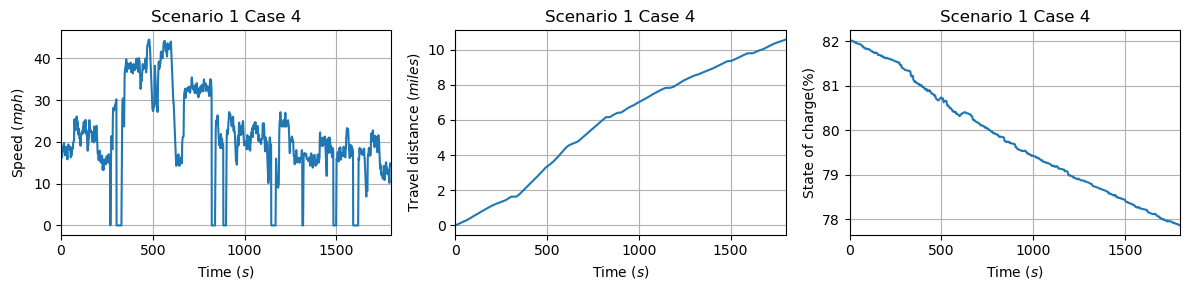

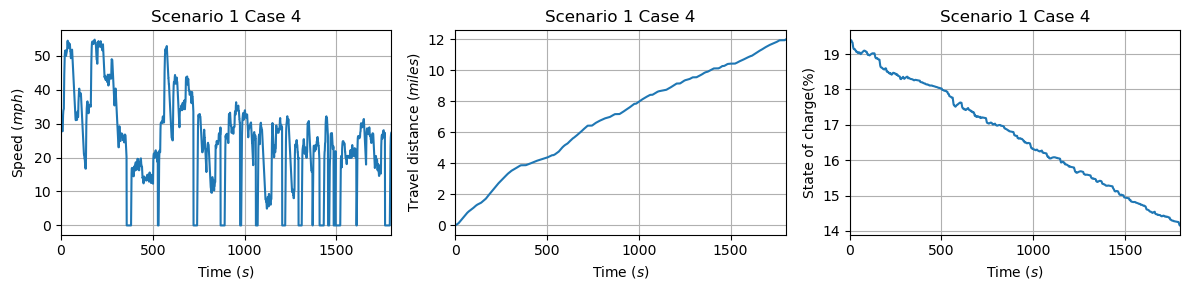

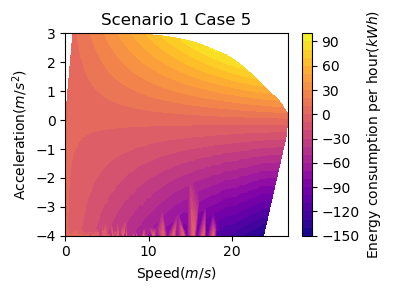

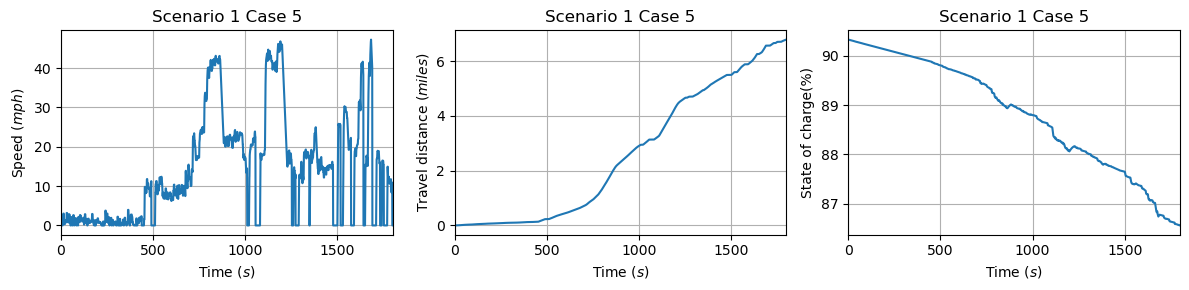

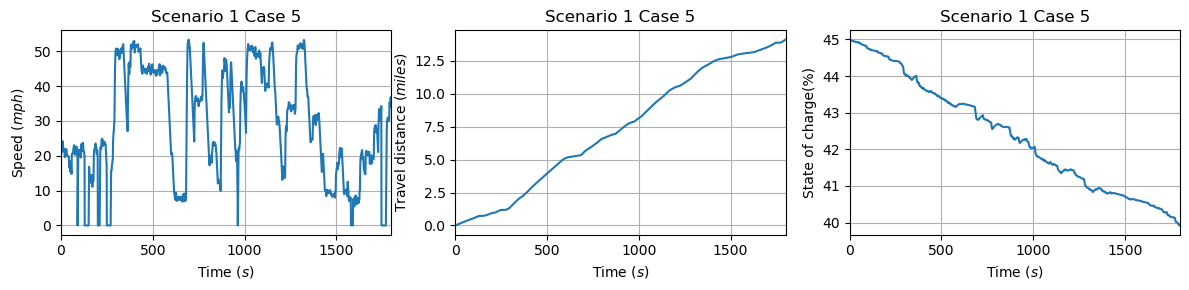

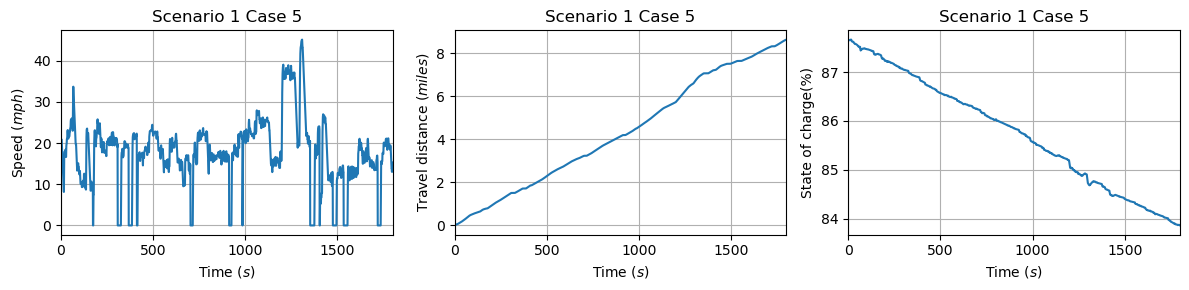

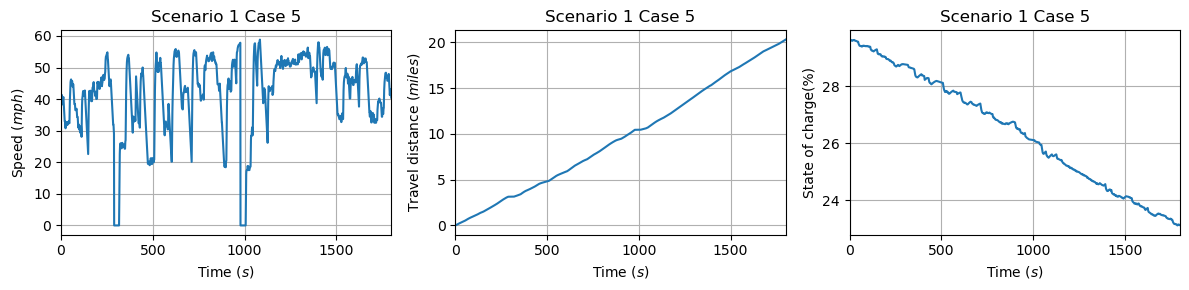

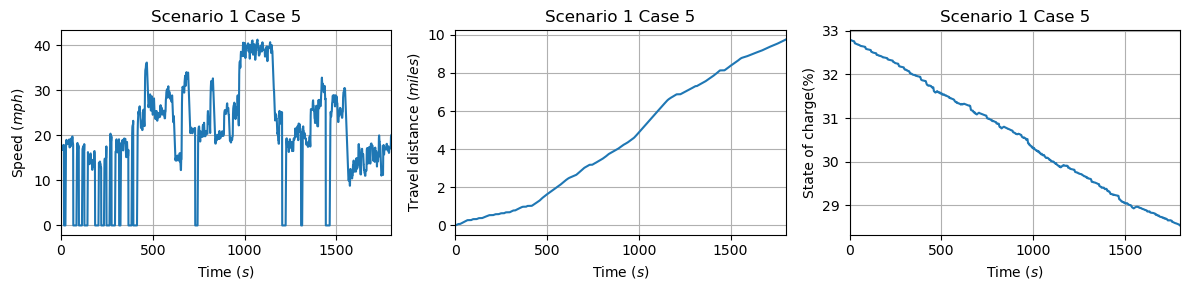

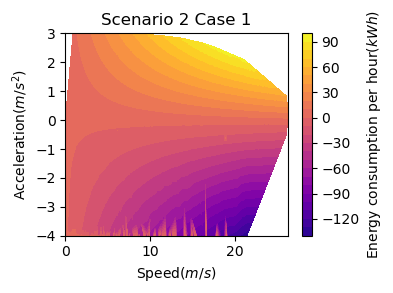

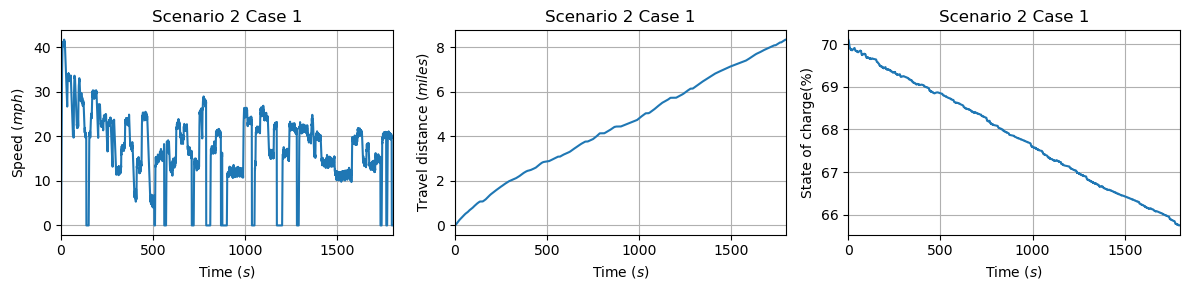

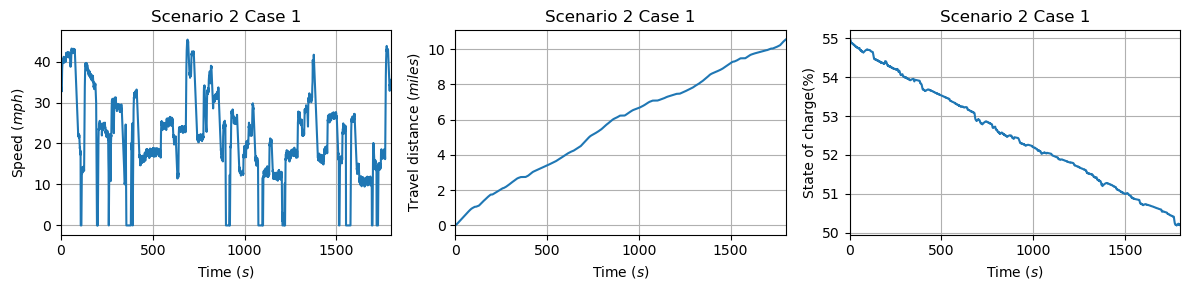

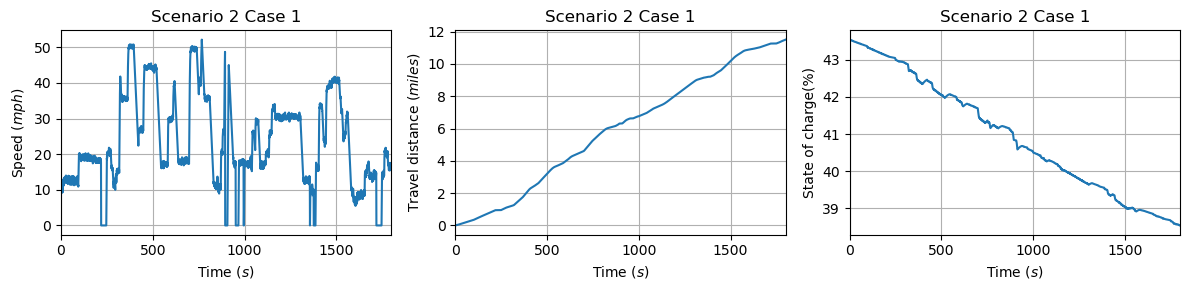

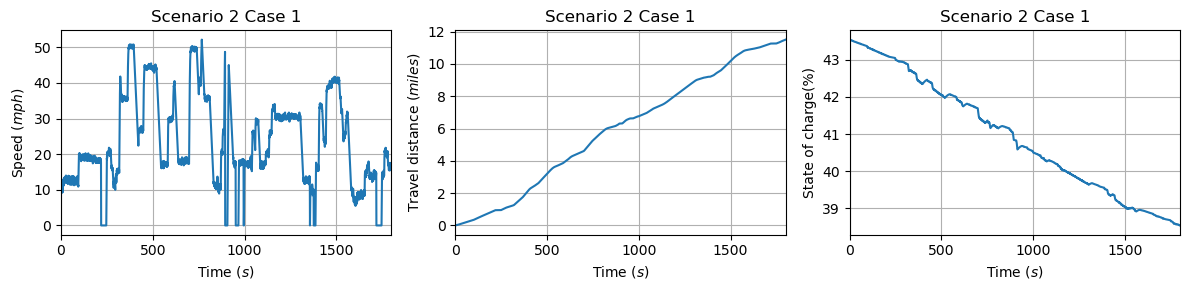

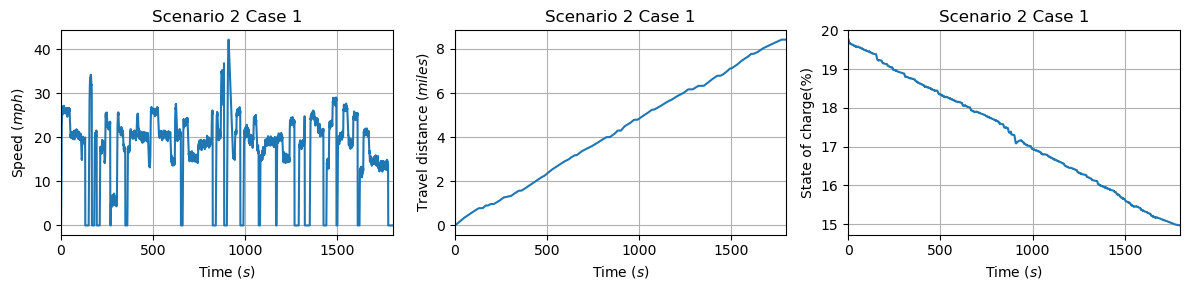

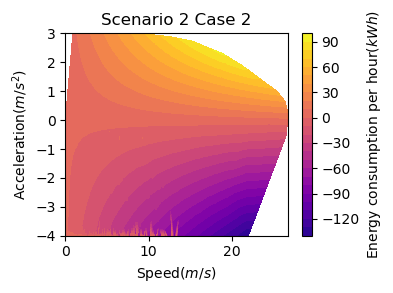

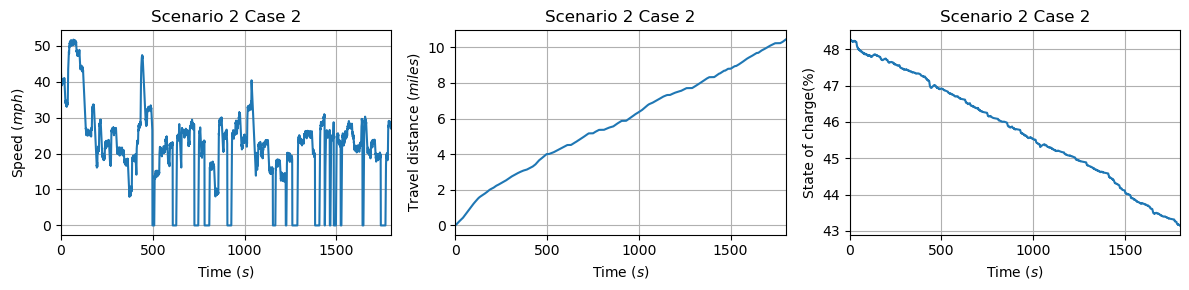

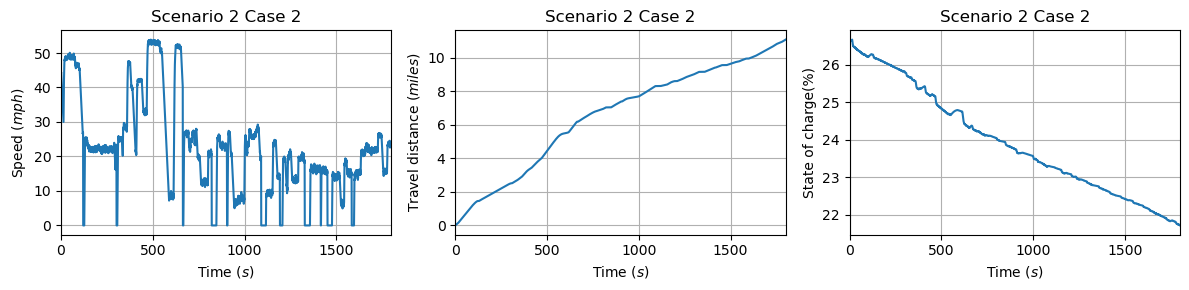

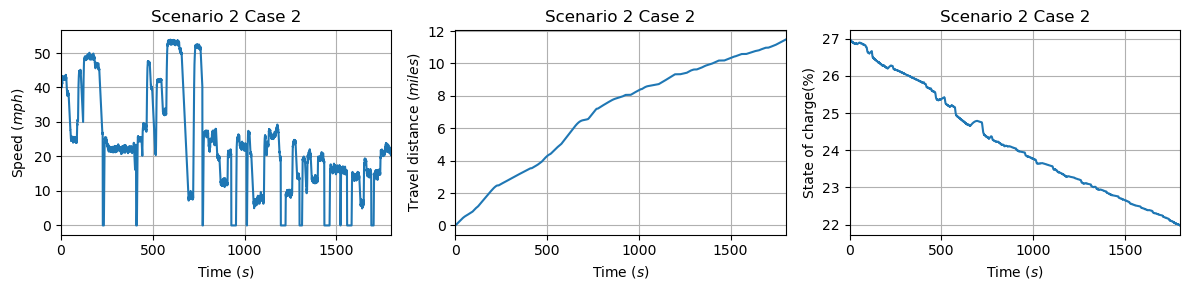

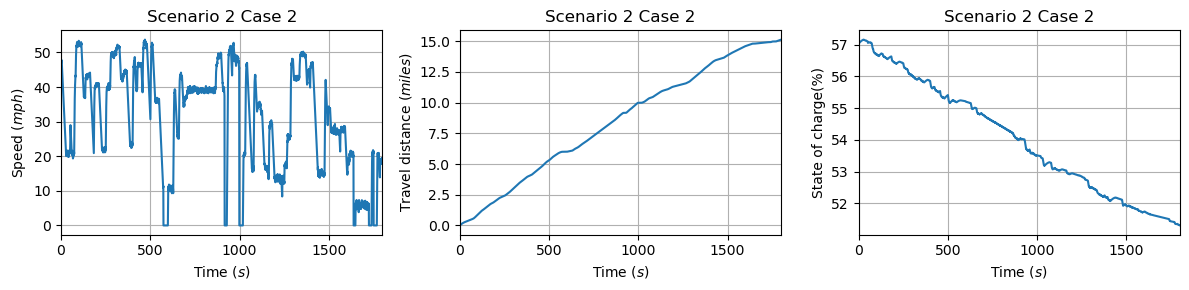

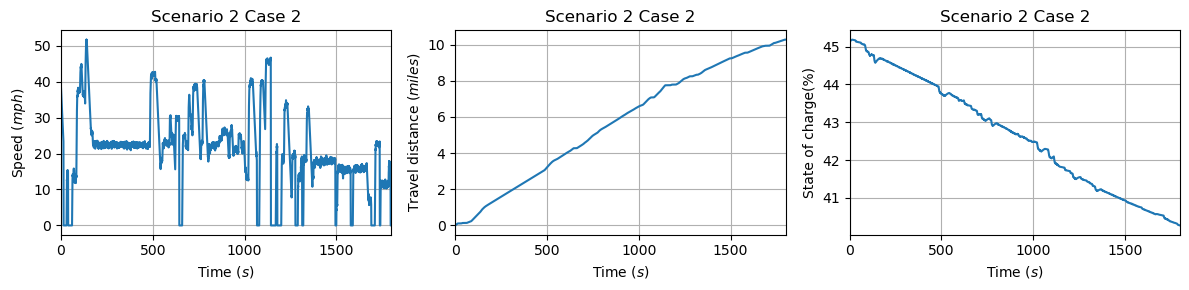

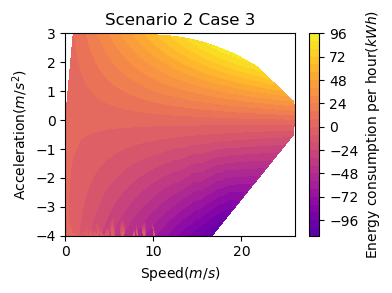

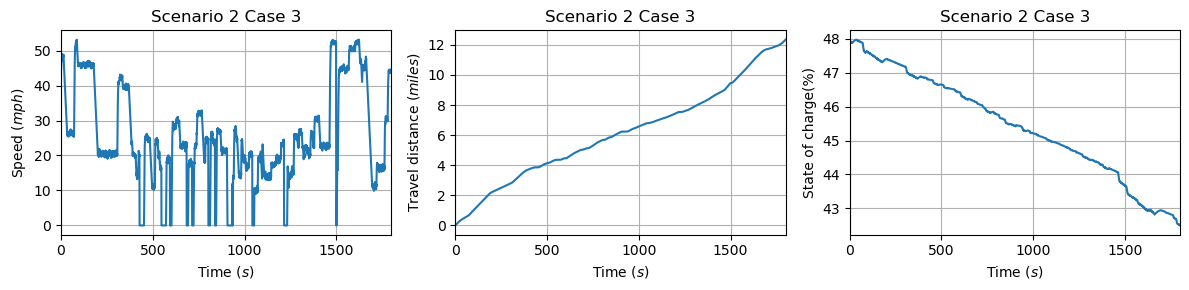

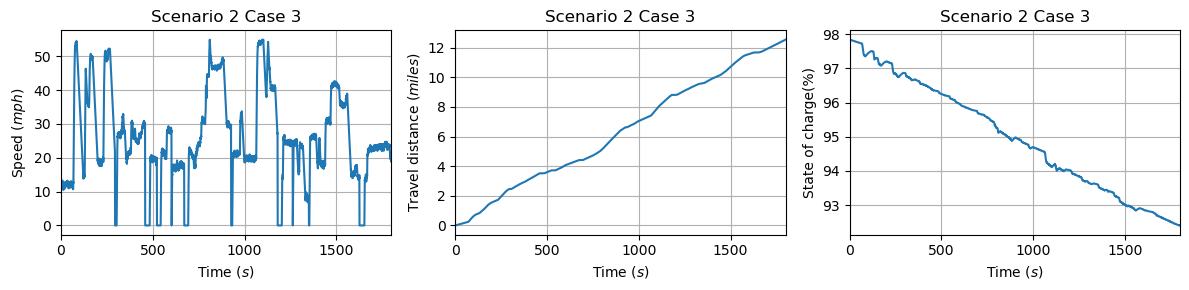

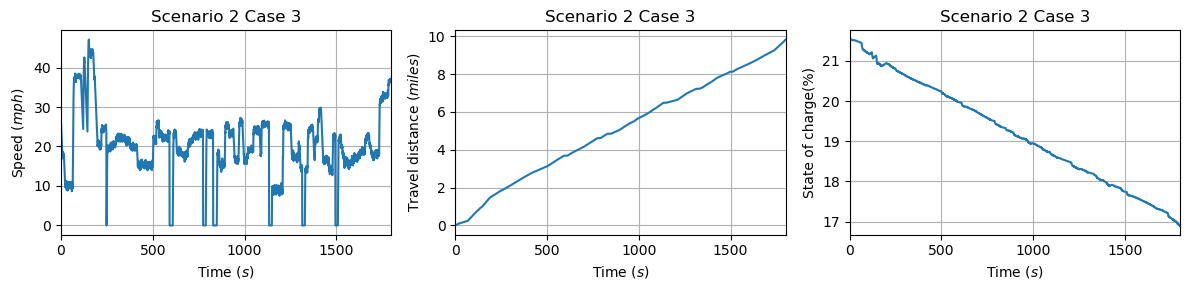

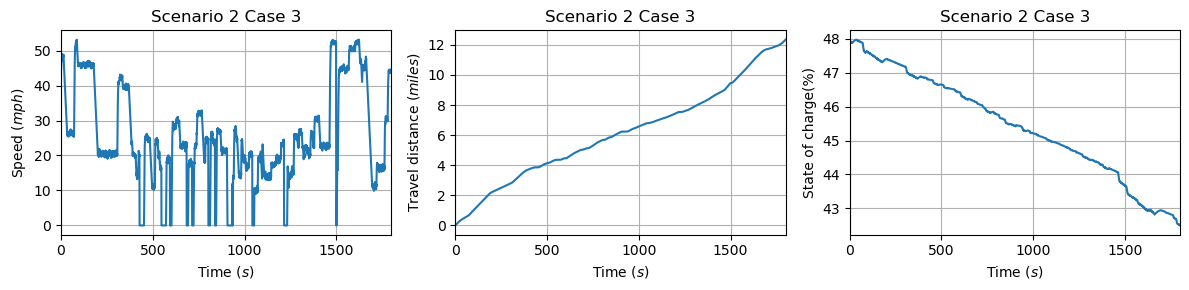

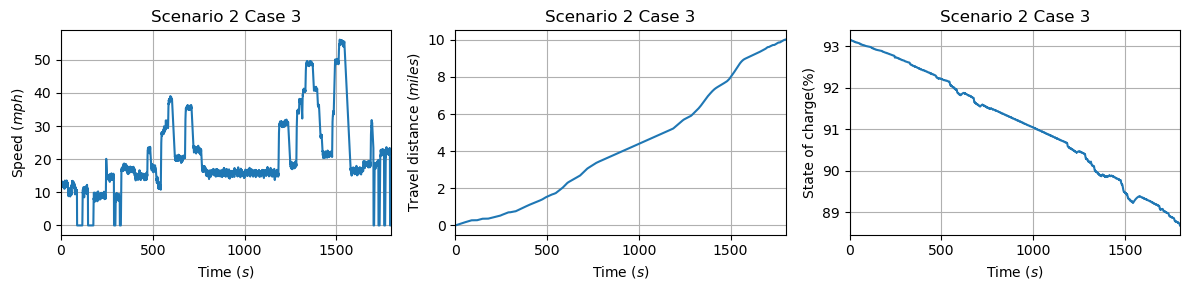

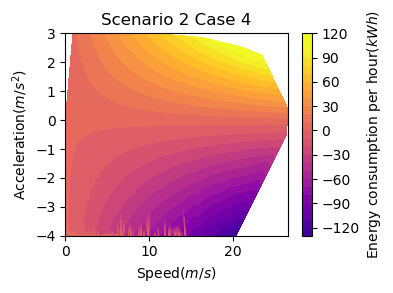

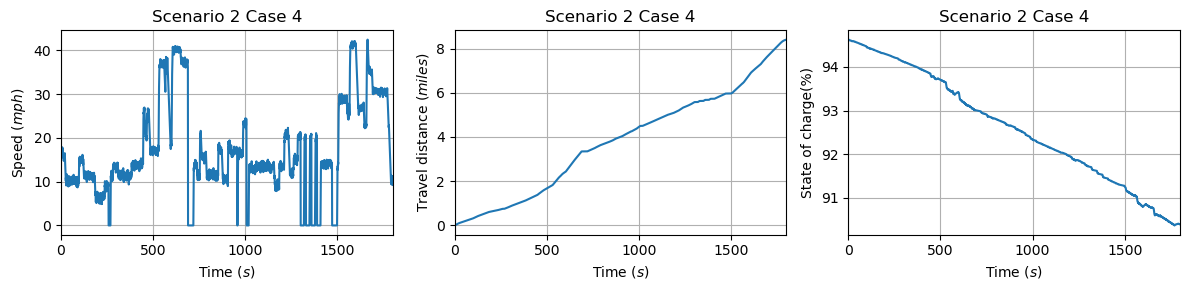

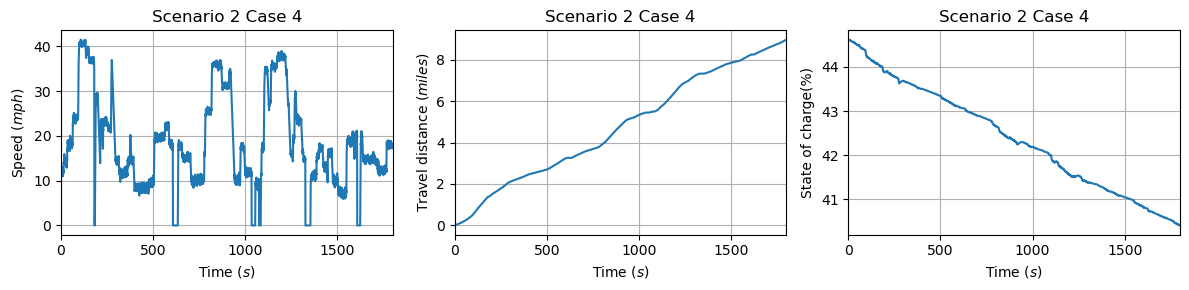

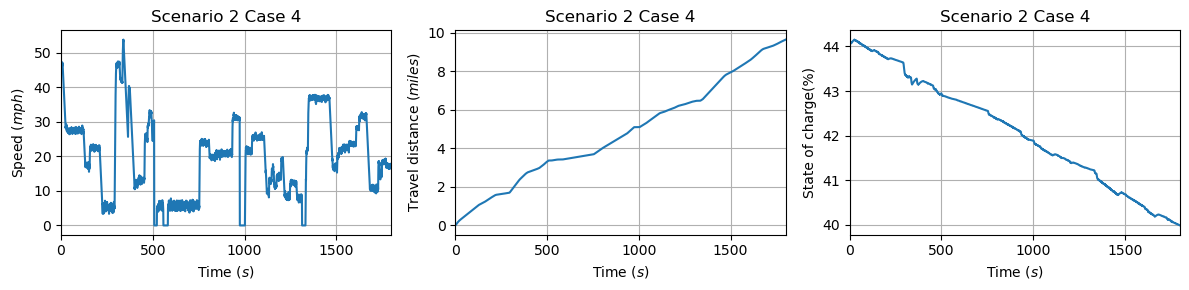

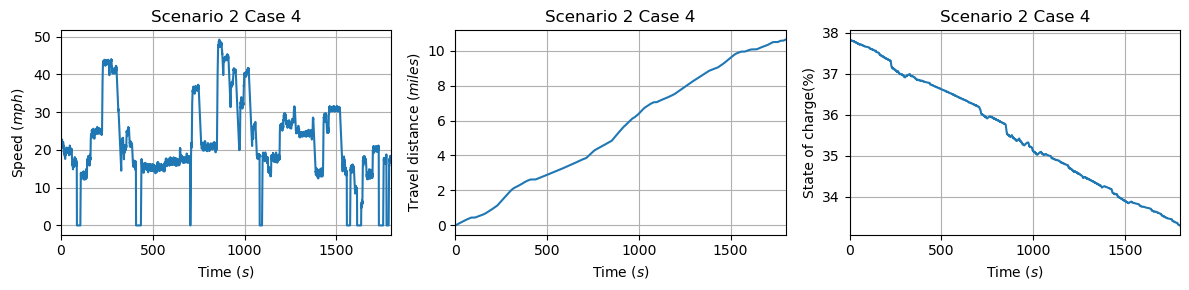

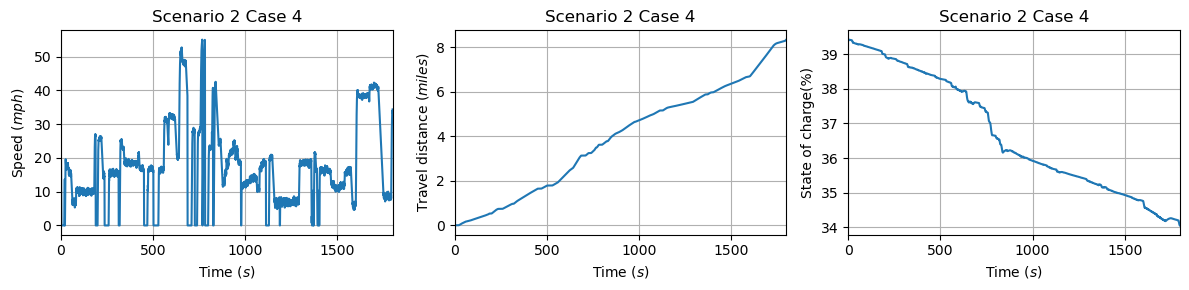

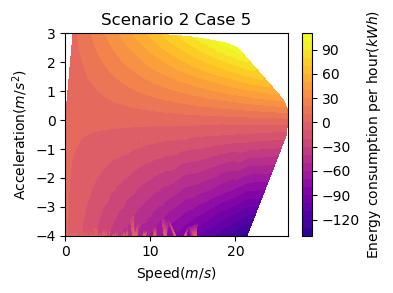

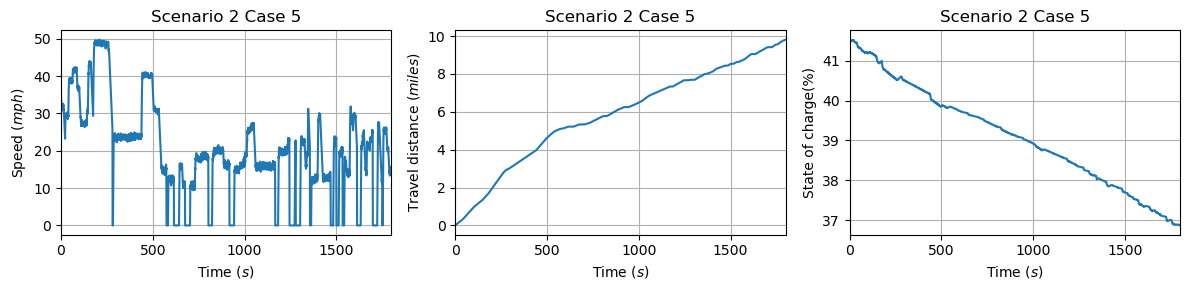

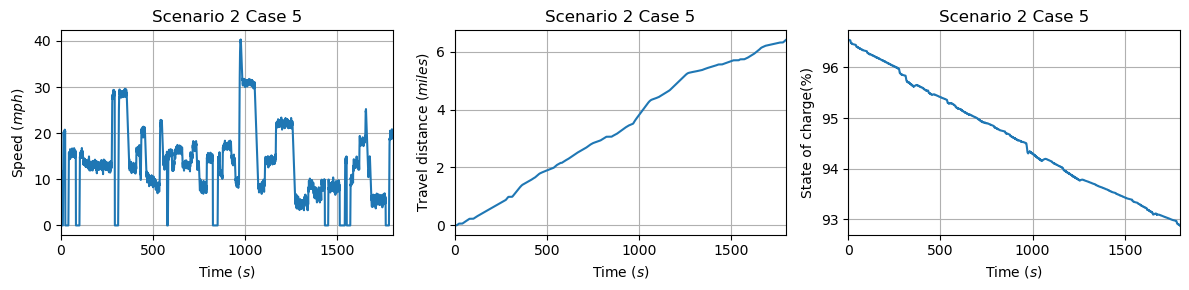

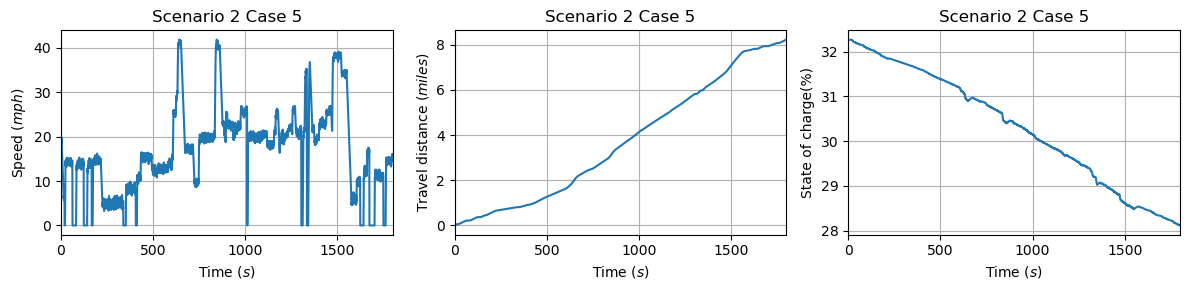

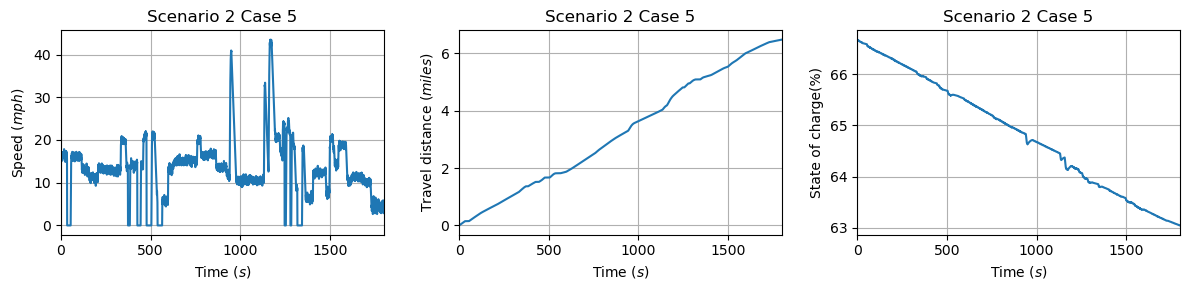

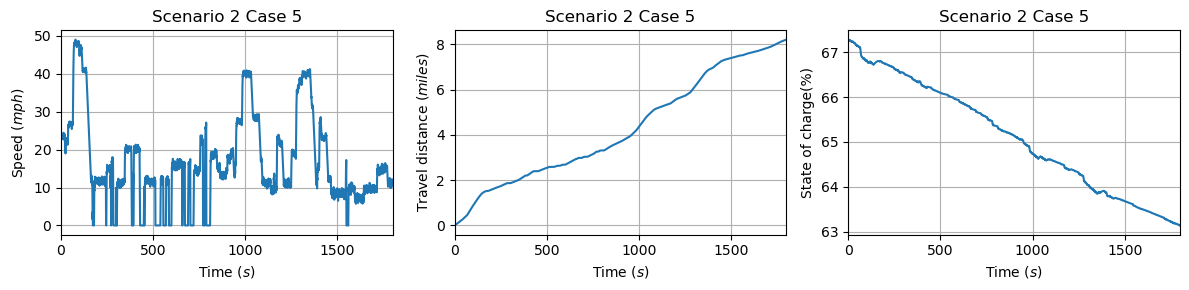

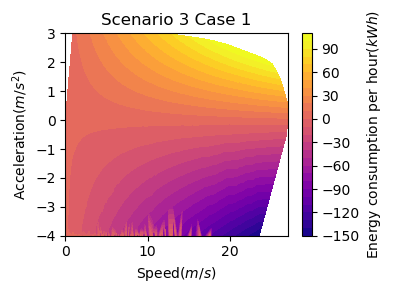

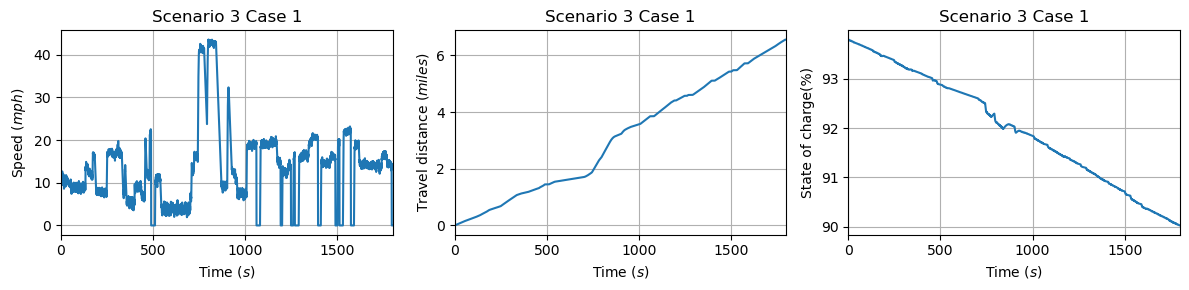

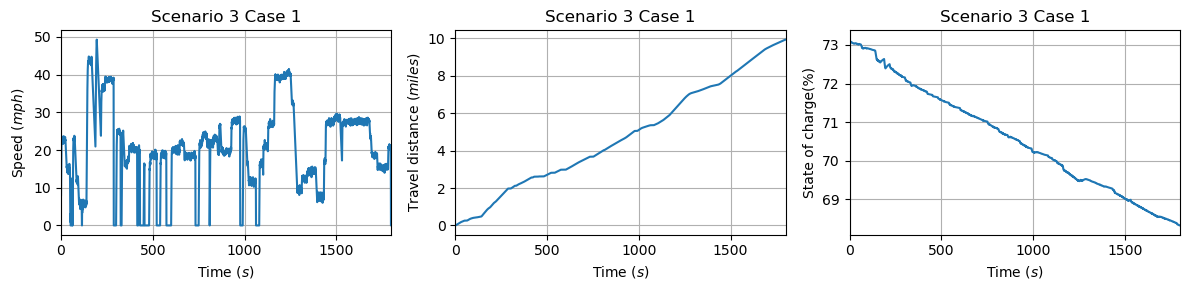

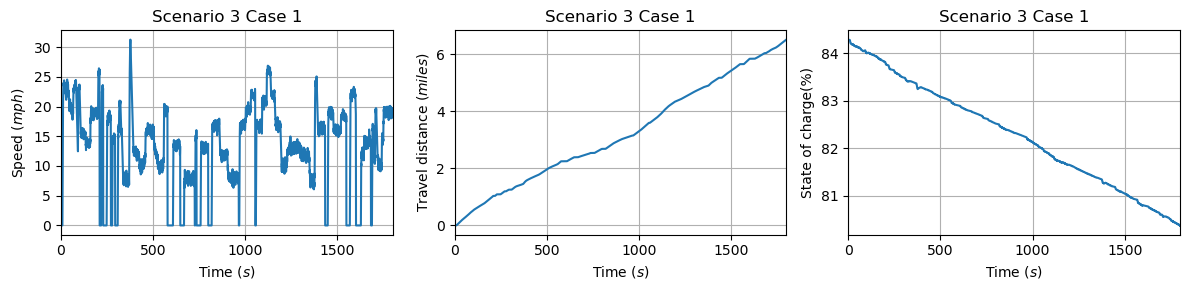

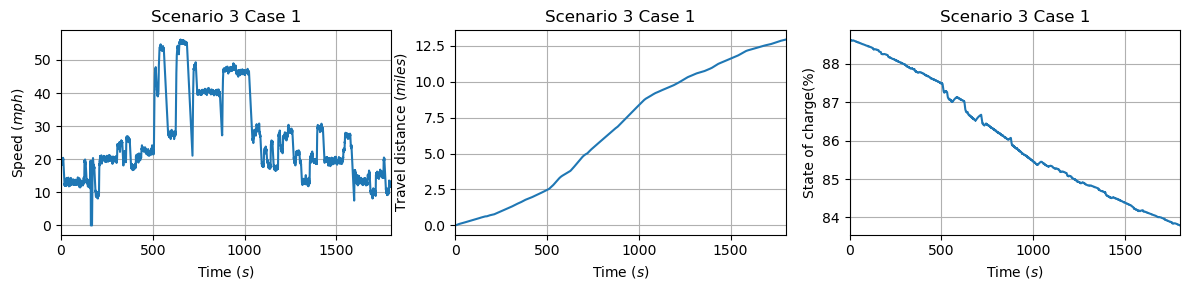

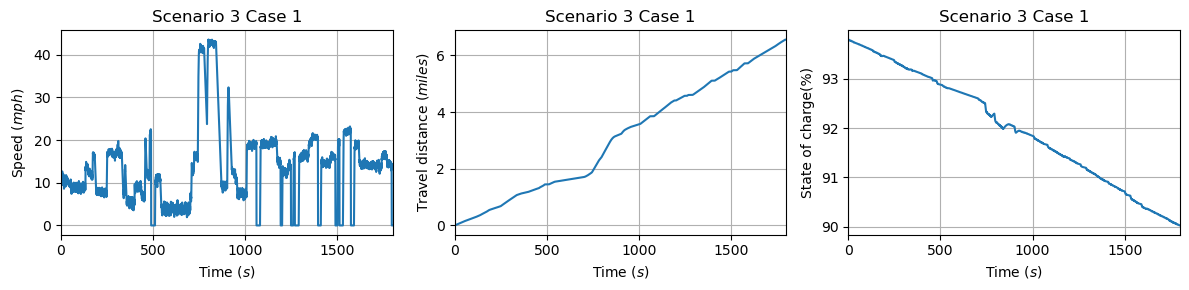

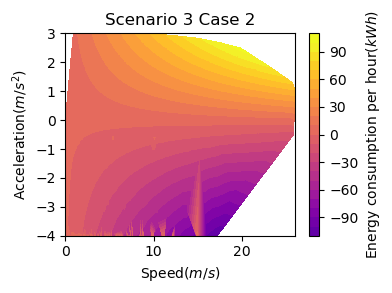

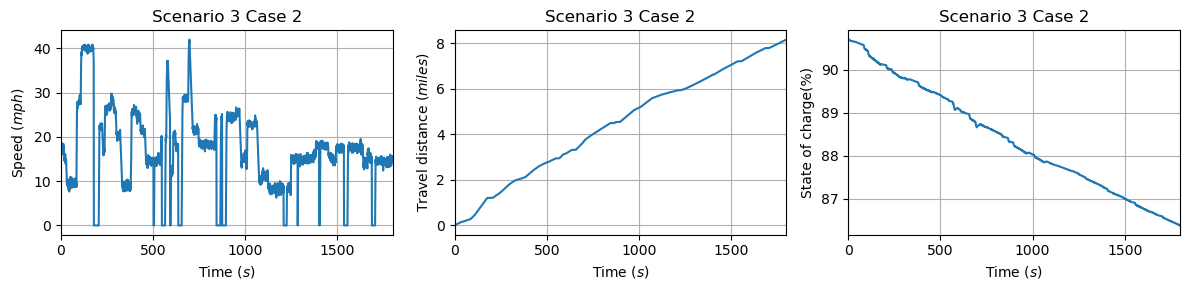

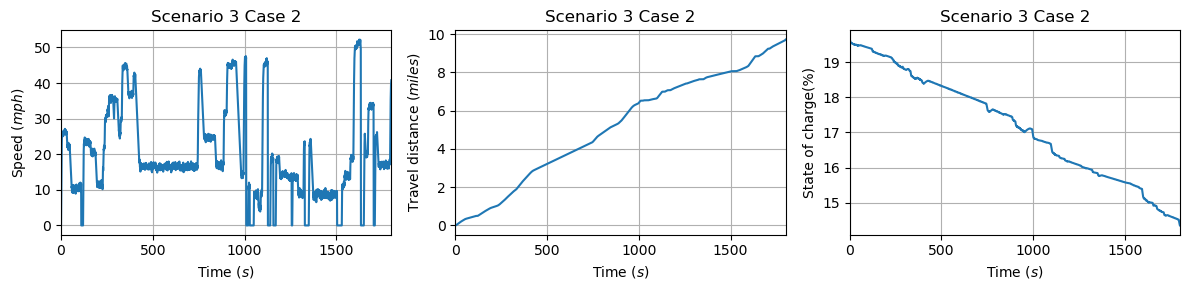

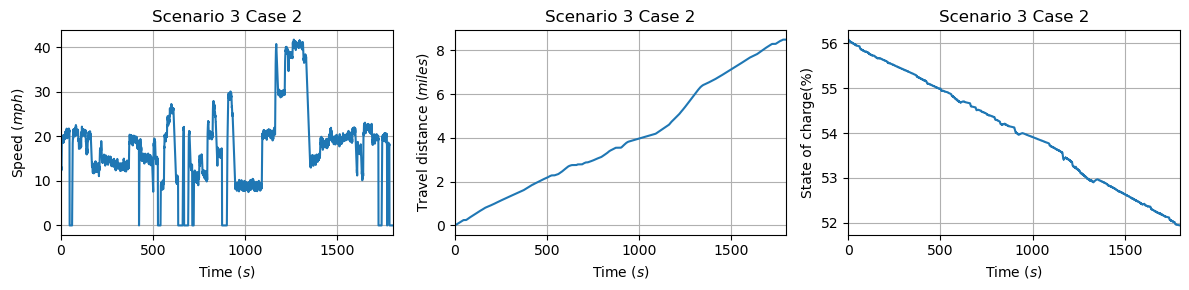

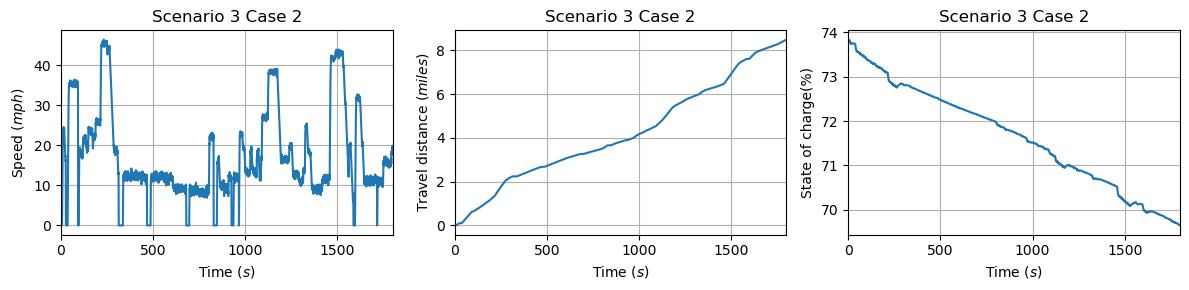

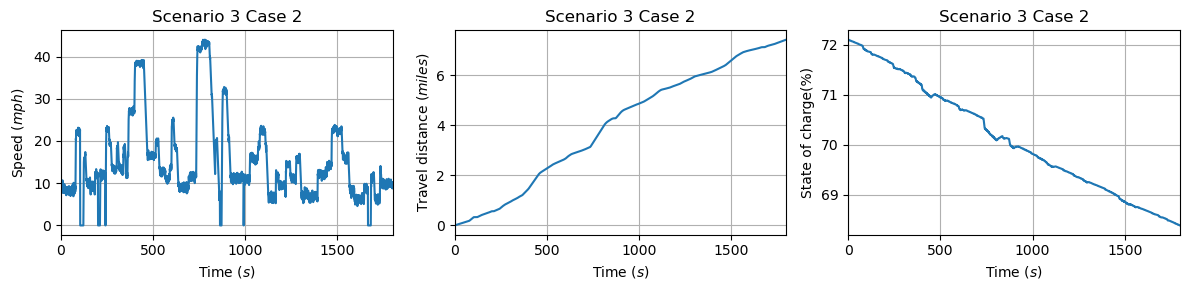

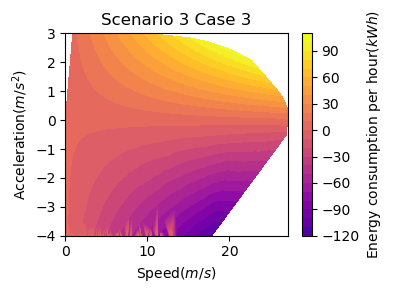

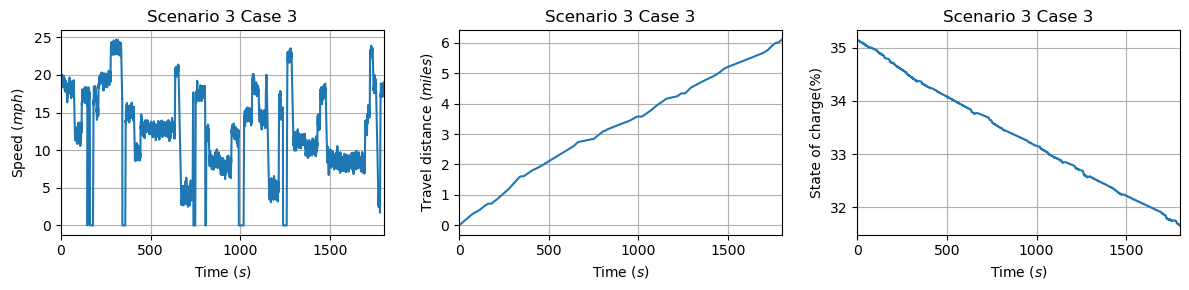

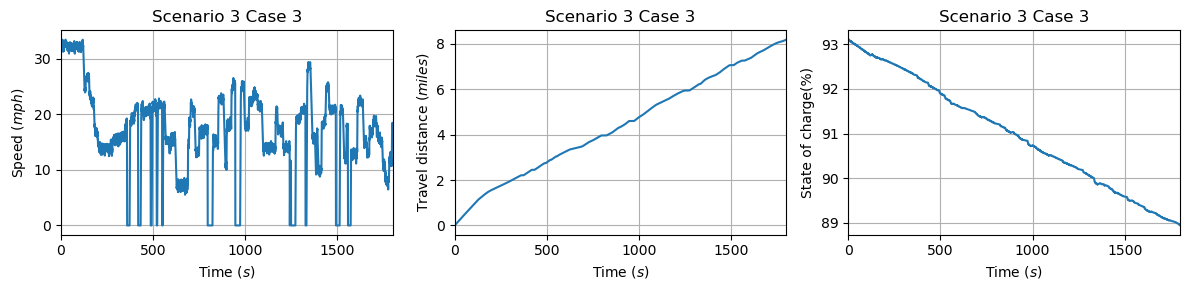

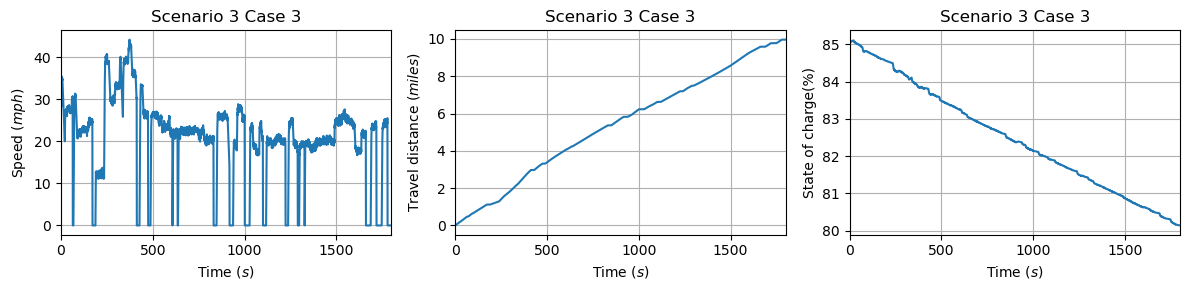

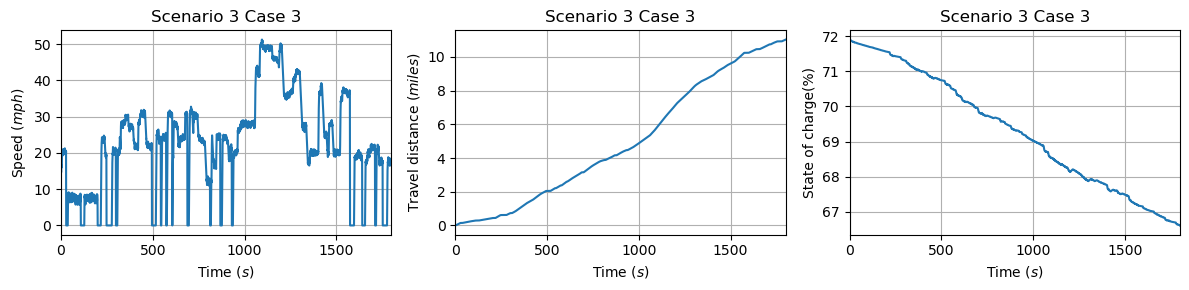

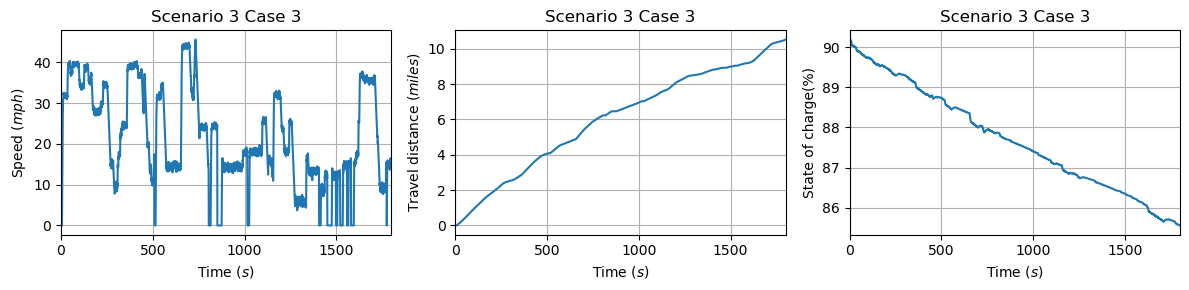

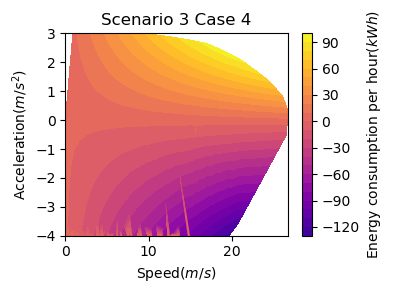

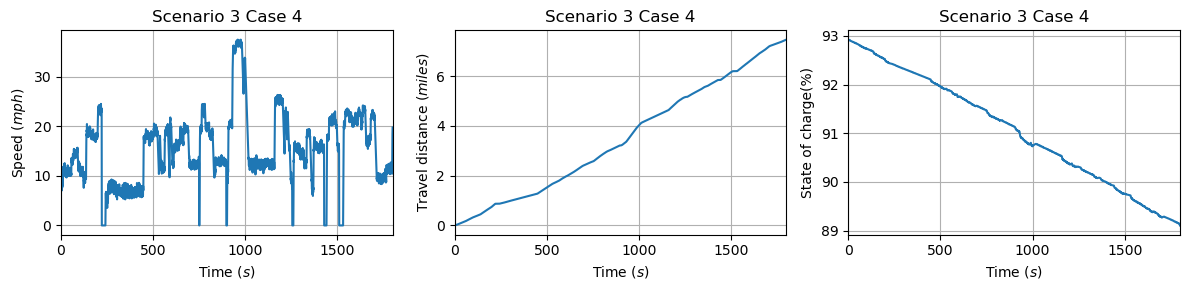

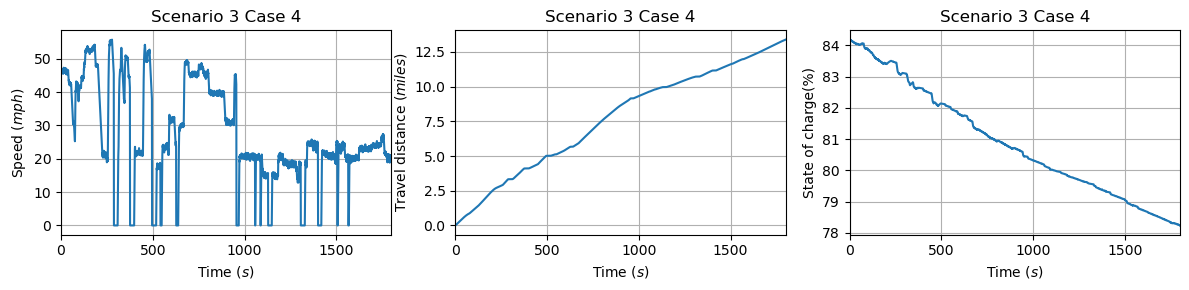

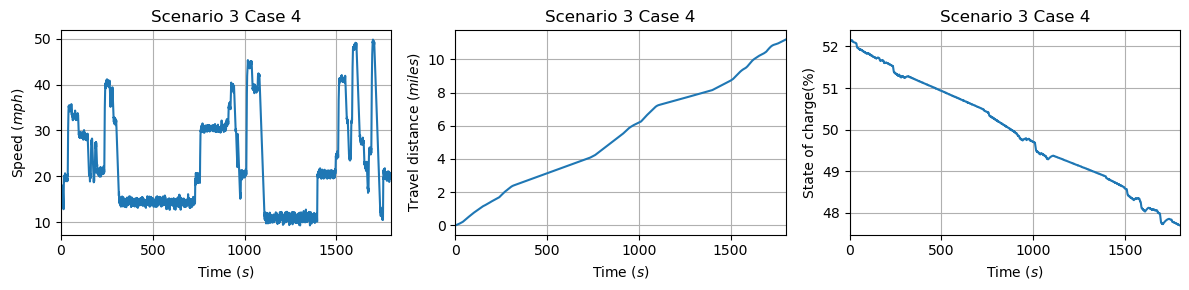

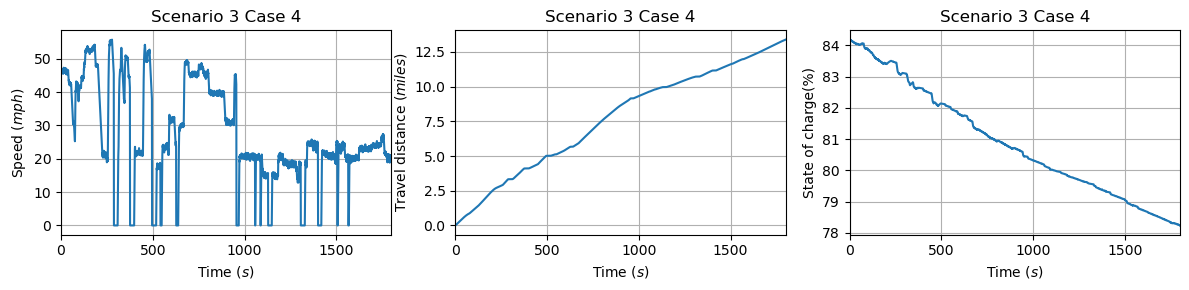

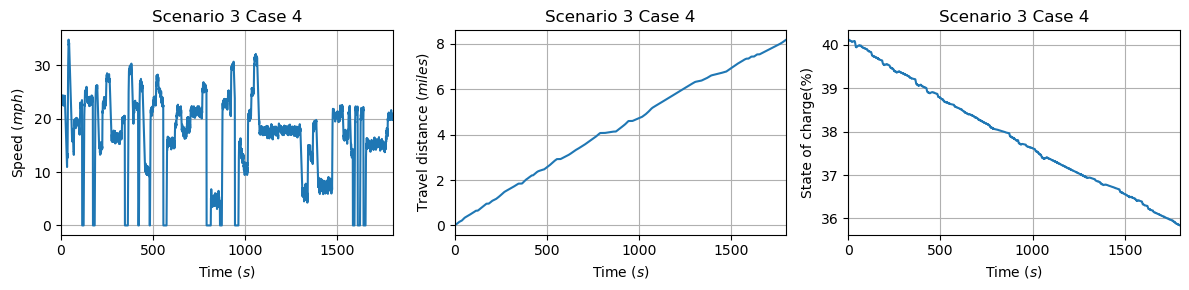

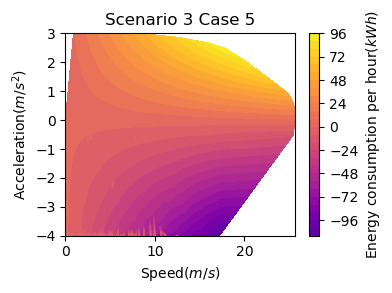

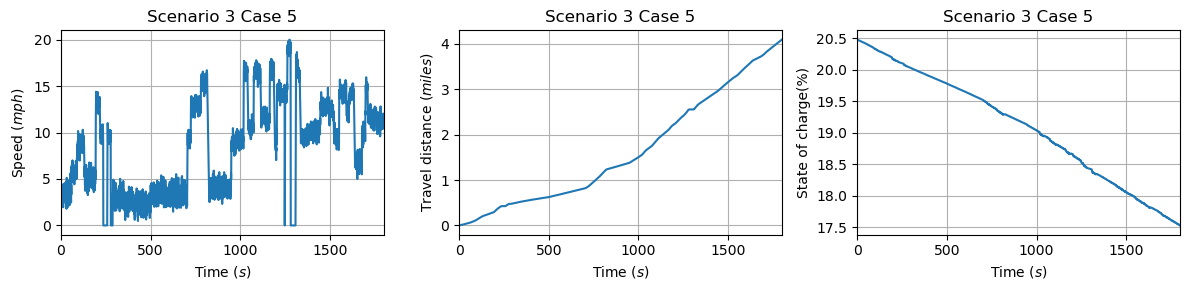

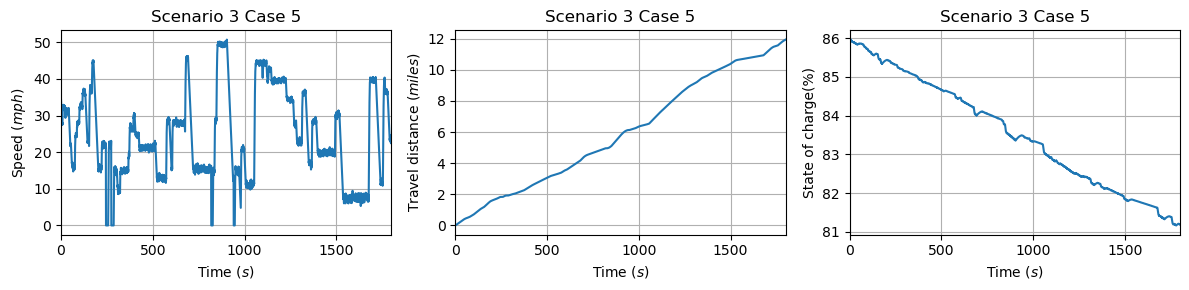

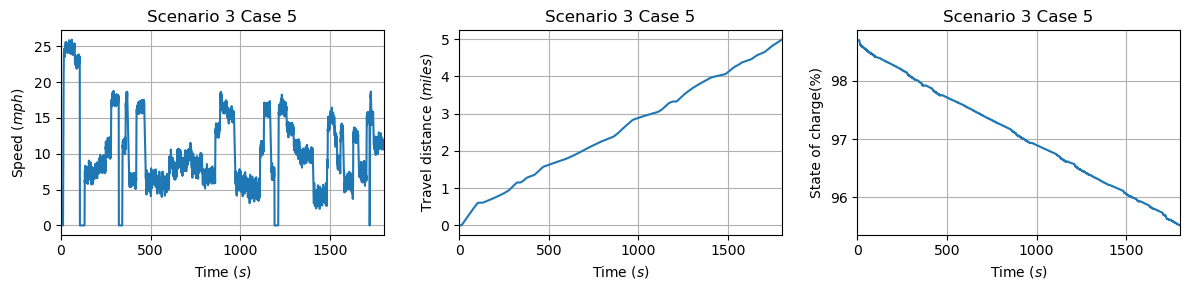

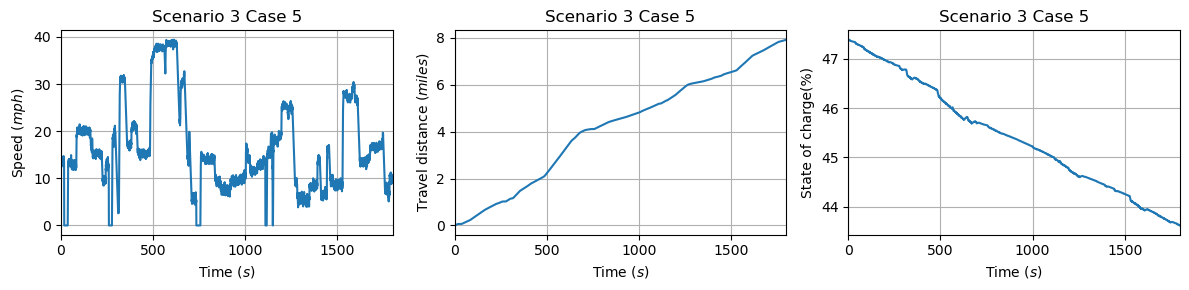

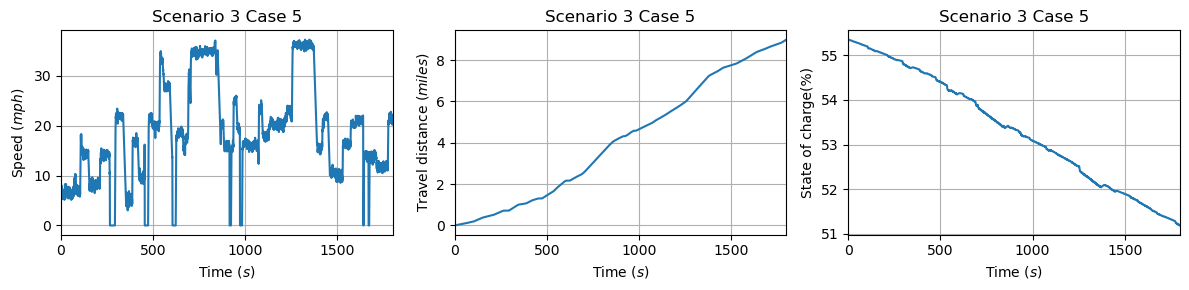

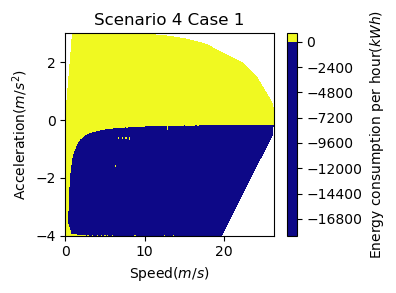

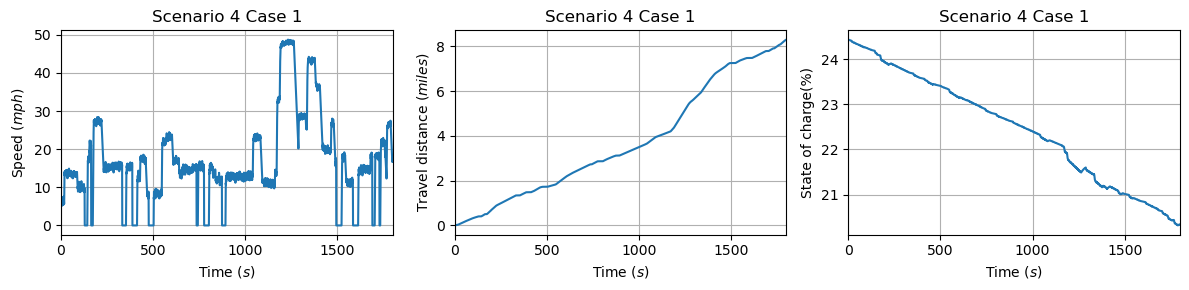

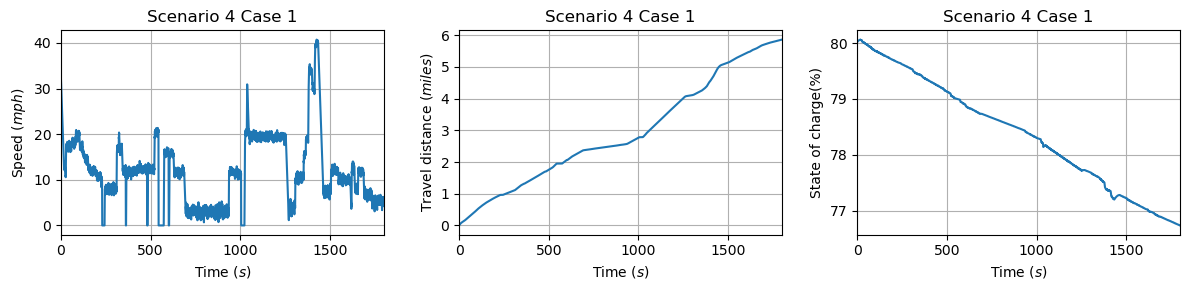

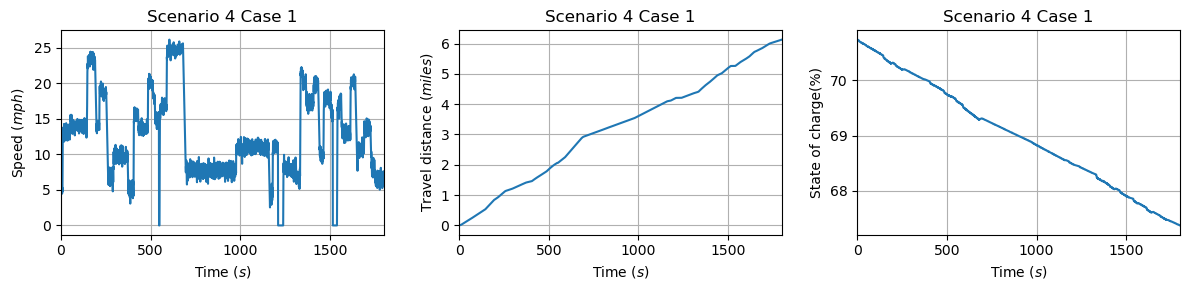

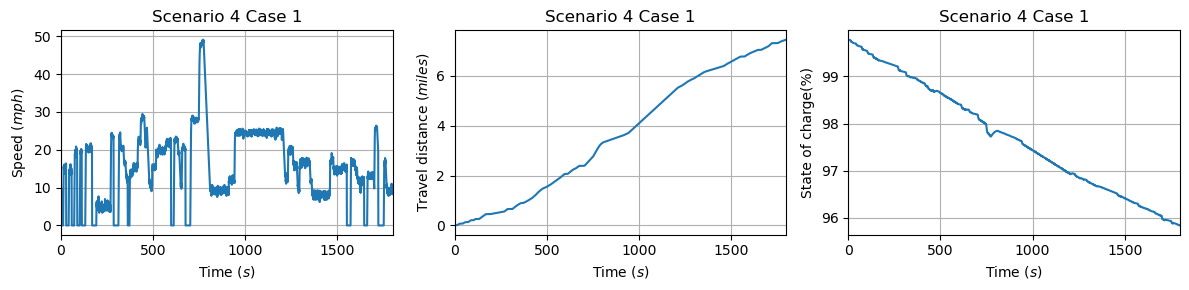

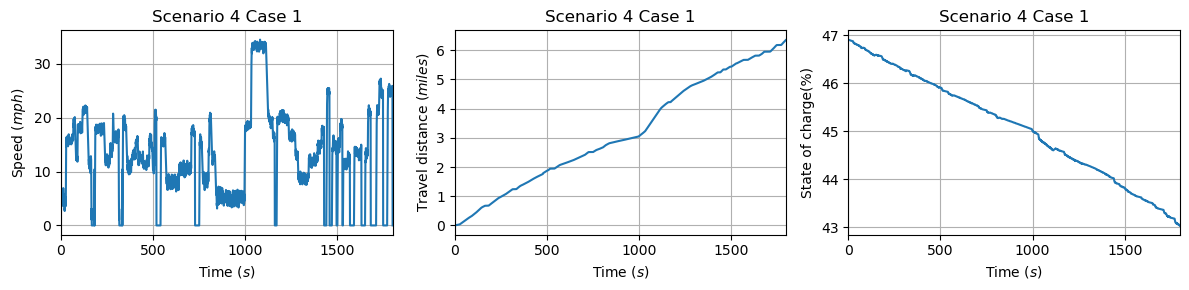

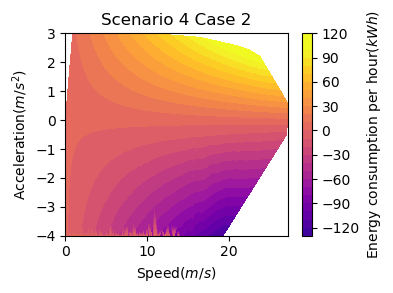

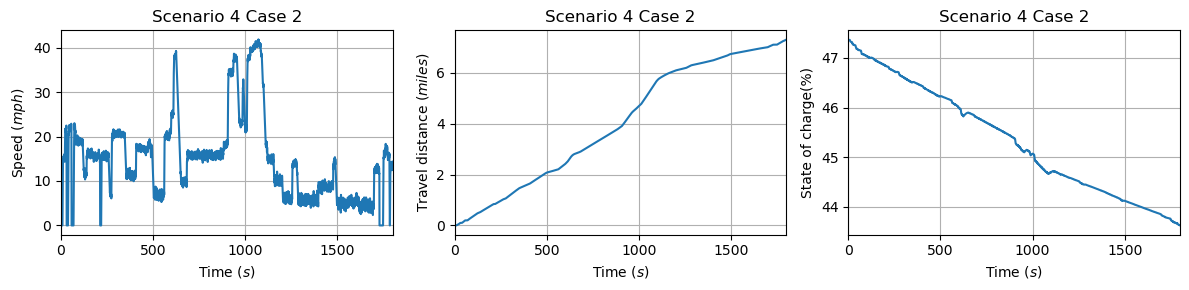

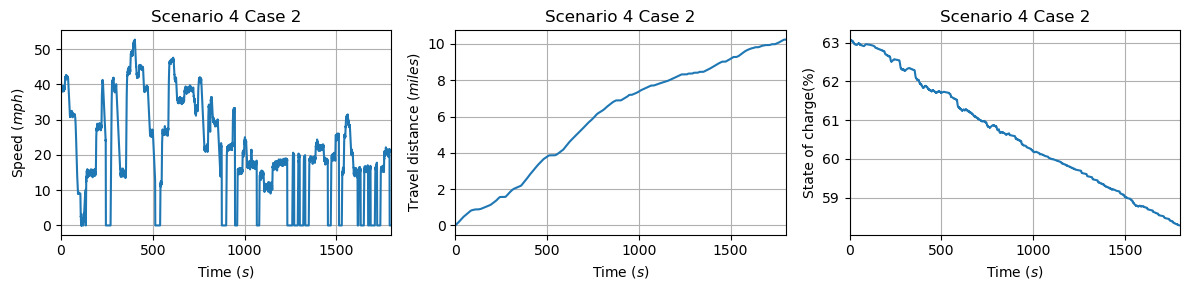

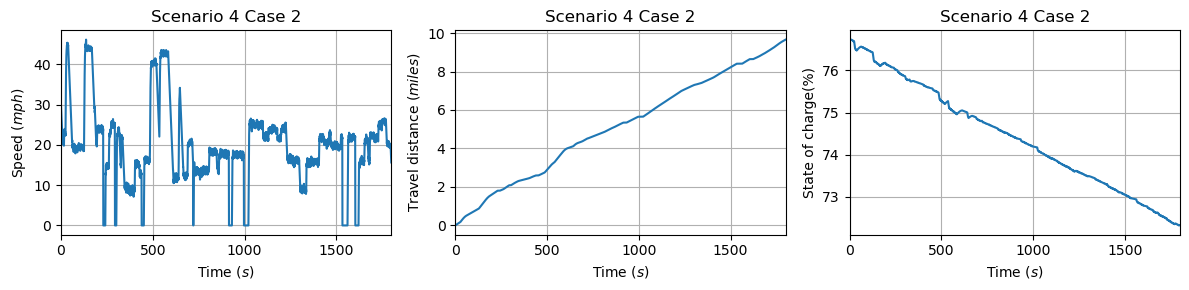

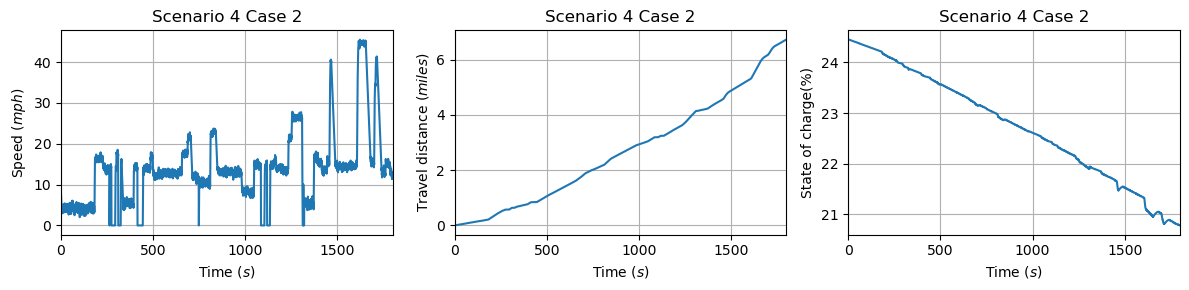

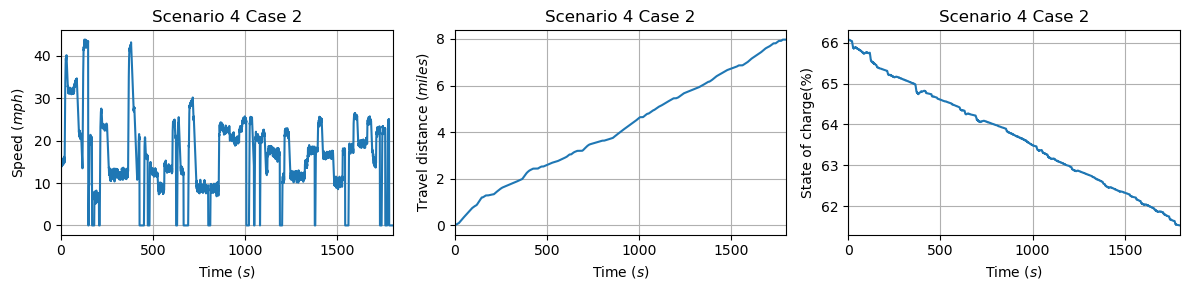

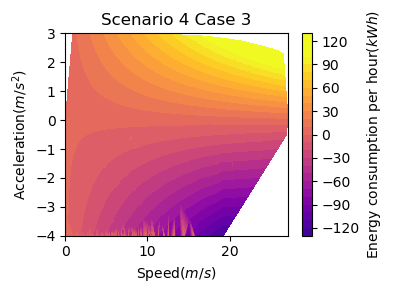

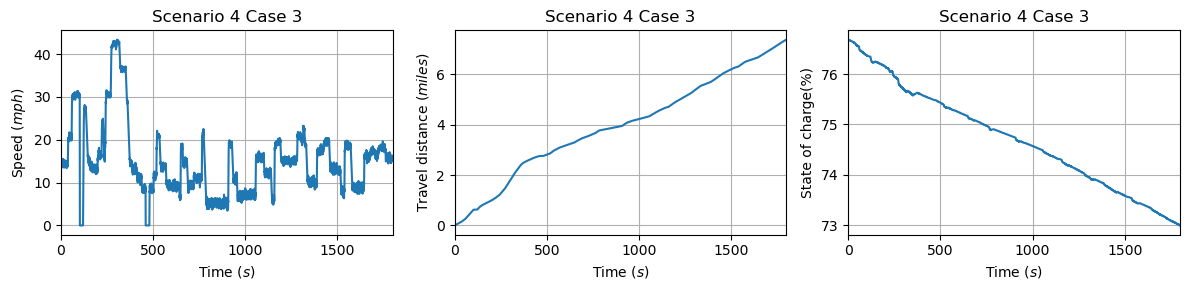

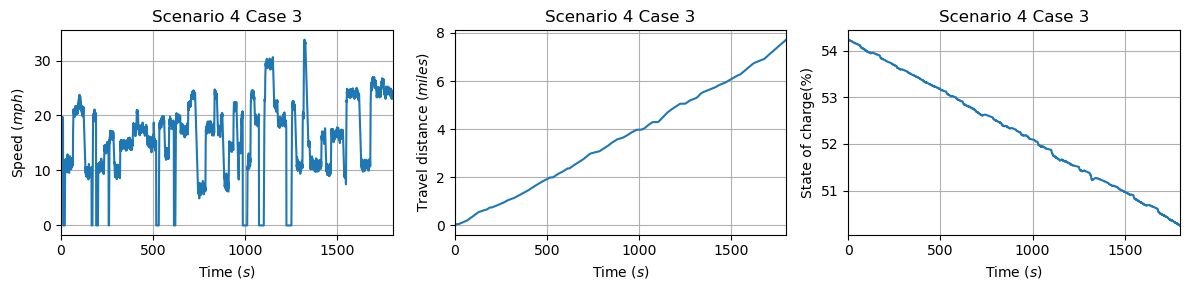

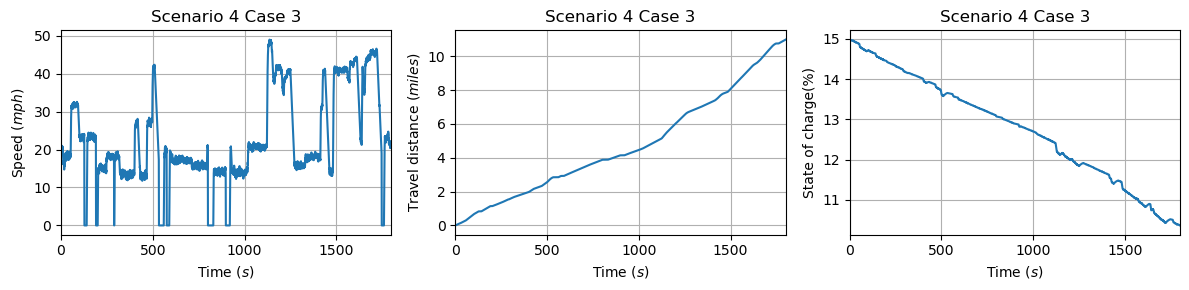

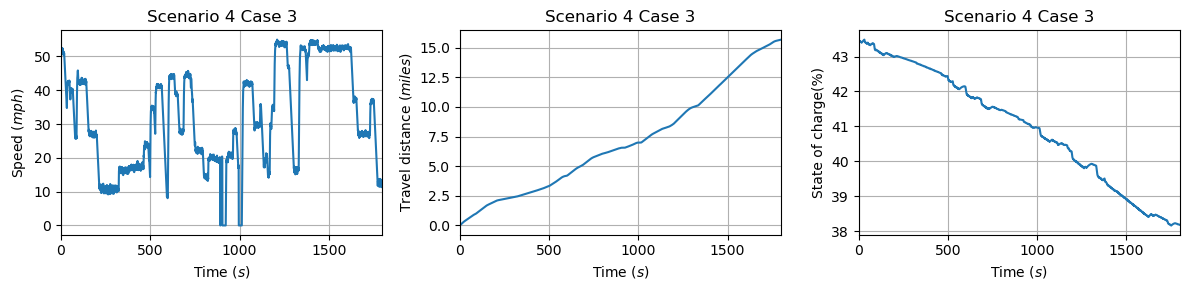

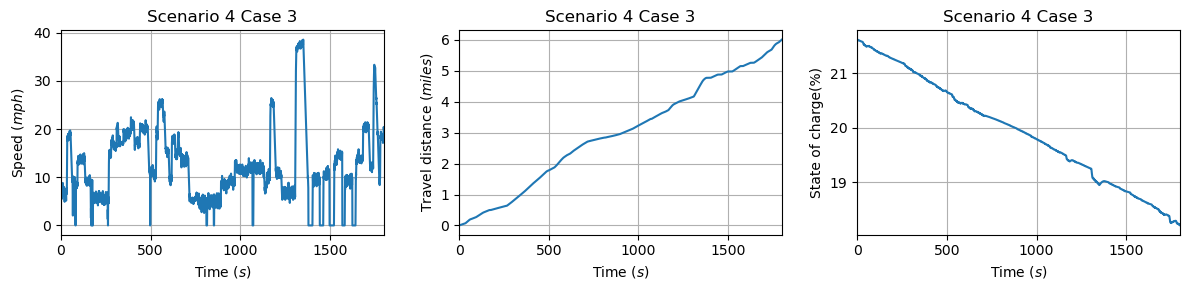

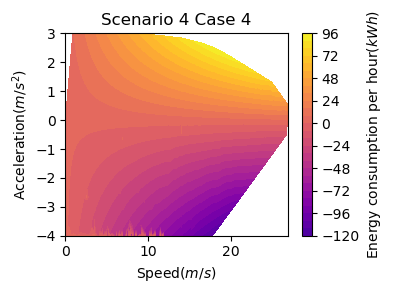

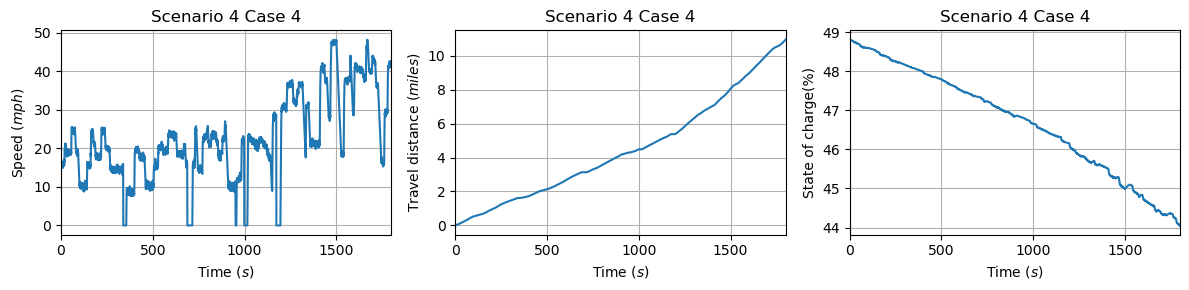

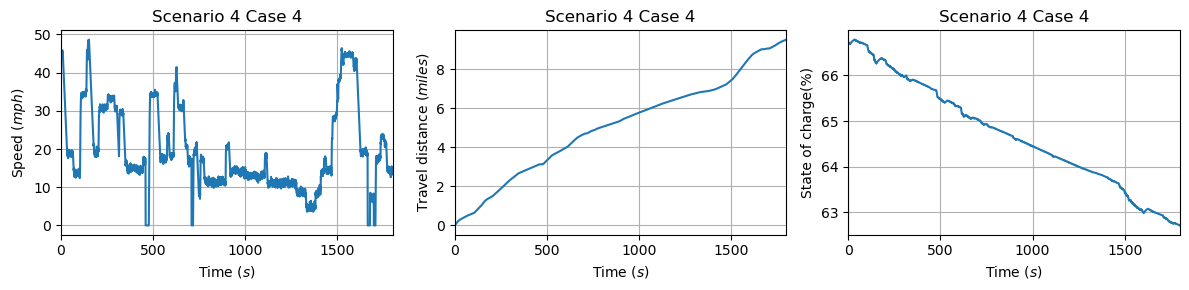

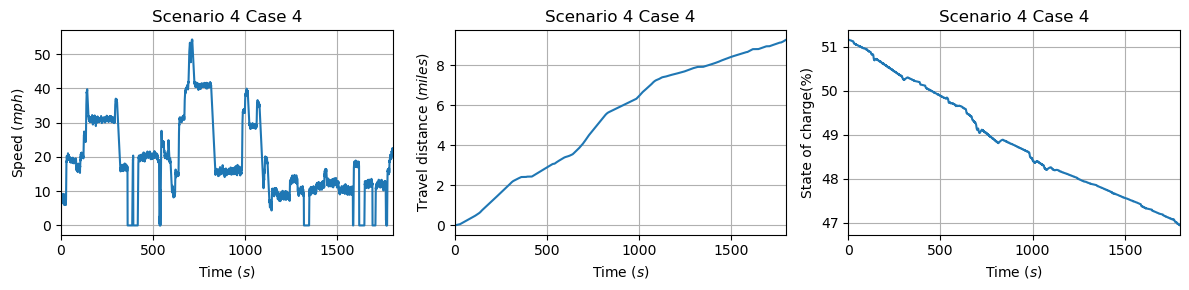

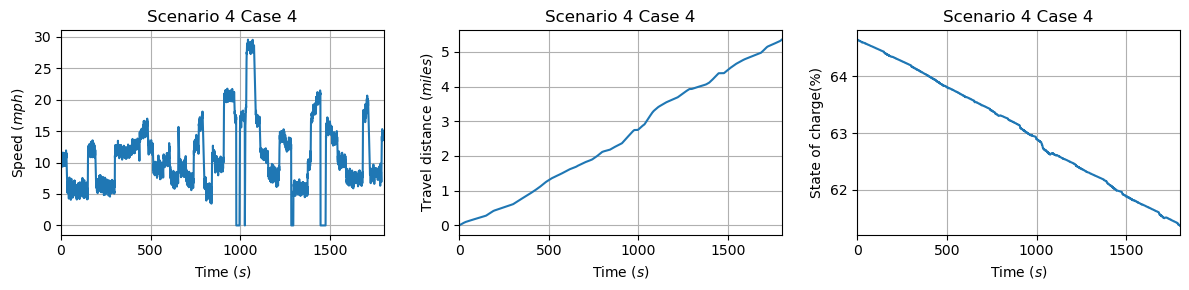

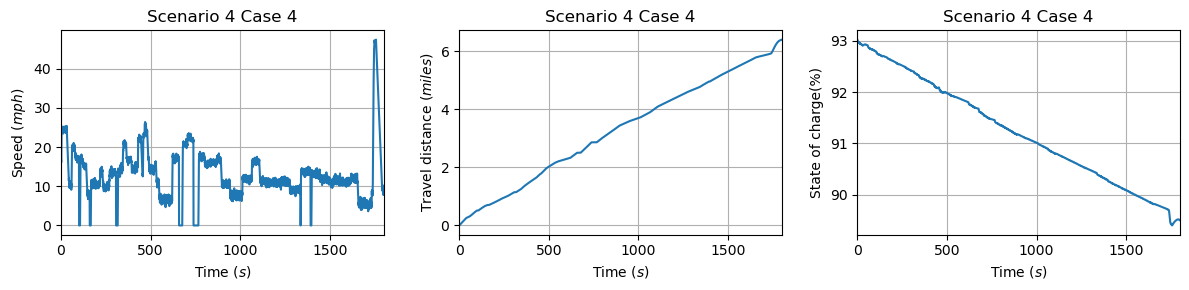

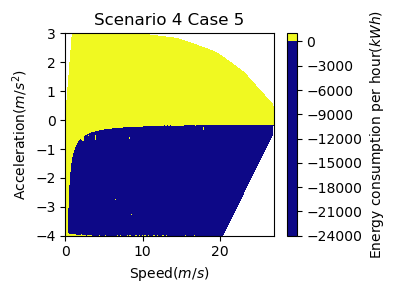

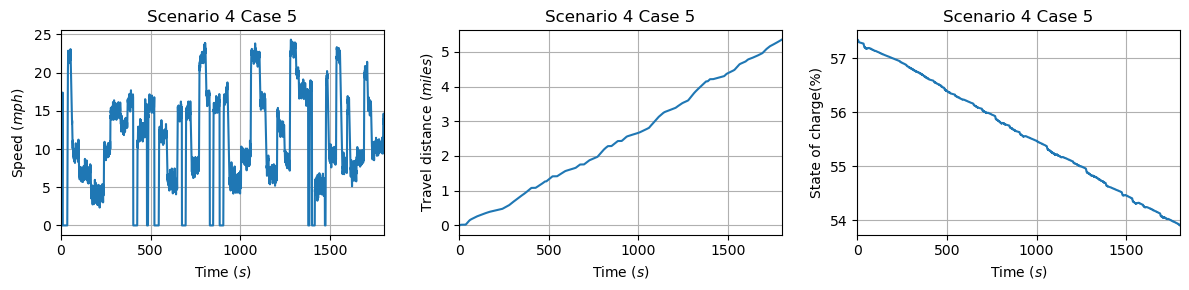

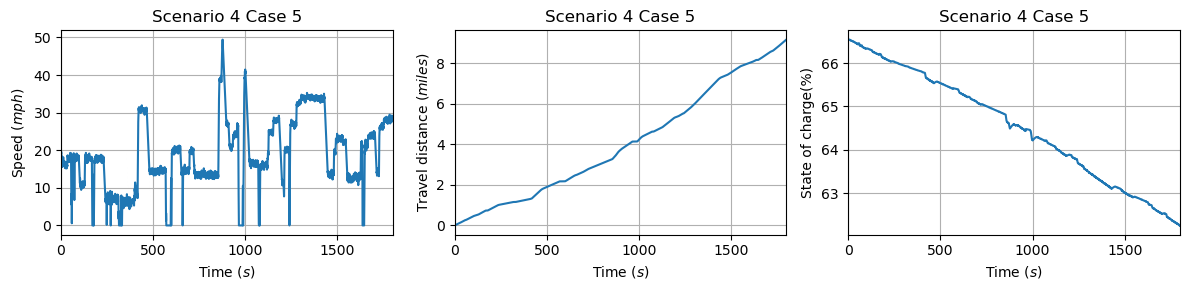

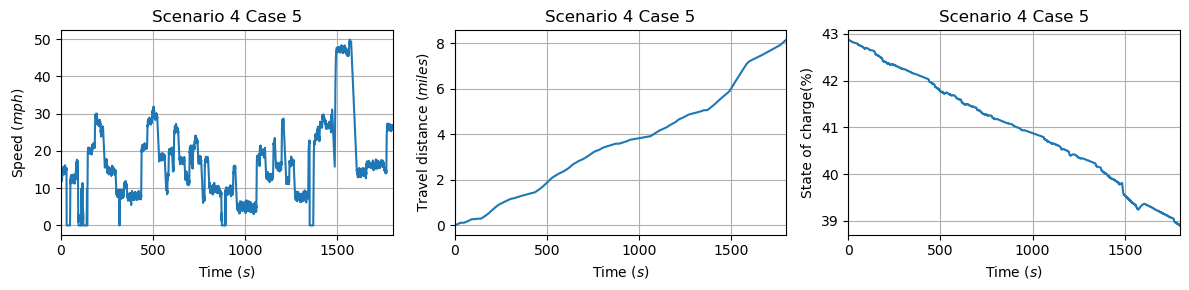

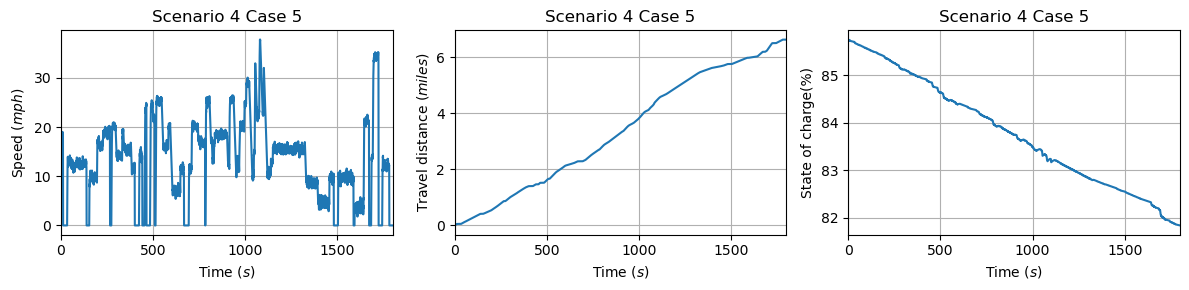

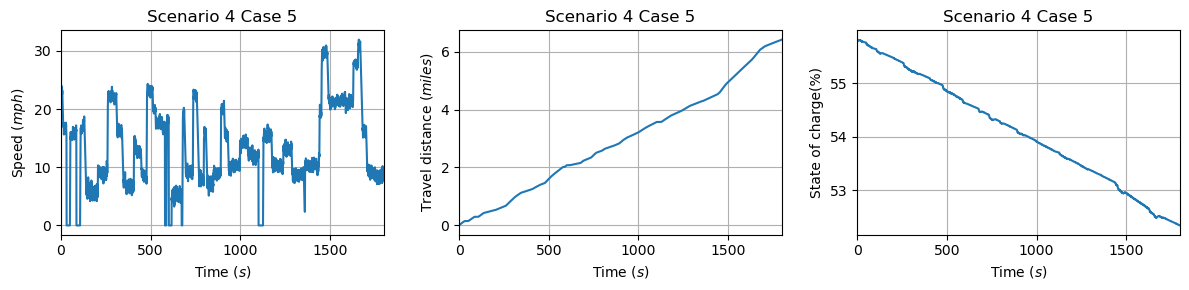

In [3]:
for i in range(len(casenames)):
    pathname = casenames[i]

    for filename in os.listdir("exp1/" + pathname + "/agg_output/4000_0"):
        if filename.startswith("Traj"):
            df_traj = pd.read_csv("exp1/" + pathname + "/agg_output/4000_0/" + filename)

    df_traj = df_traj.sort_values(['vehicleID', 'tick'], ascending = True)

    # Energy consumption versus speed and acceleration
    fig, ax = plt.subplots(figsize=(4,3))
    # ax = plt.axes(projection="3d")

    df_sample = df_traj
    
    cf = ax.tricontourf(df_sample['speed'], df_sample['acc'], df_sample['tick_consume']*3600/0.3, 25, cmap=cm.plasma, vmin=-150, vmax=100)
    
    cbar = plt.colorbar(cf,)
    cbar.set_label('Energy consumption per hour($kWh$)')
    
    # ax.scatter3D(df_sample['speed'], df_sample['acc'], df_sample['tick_consume']*3600/0.3, c = df_sample['tick_consume'], cmap = cm.plasma)

    ax.set_xlabel(r"Speed($m/s$)")
    ax.set_ylabel(r"Acceleration($m/s^2$)")
    # ax.set_zlabel(r"Energy consumption per hour($kWh$)")
    plt.title("Scenario {} Case {}".format(i//5+1, i % 5 + 1))
    plt.tight_layout()
    plt.savefig("fig/exp1/energy_consumption_"+str(i) + ".png")
    plt.savefig("fig/exp1/energy_consumption_"+str(i) + ".pdf")

    # process the data to obtain the accumulated trip distance, tripID
    df_traj['tripID'] = [0] + list((df_traj.shift(-1).tick - df_traj.tick)>1)[:-1]

    df_traj['tripDist'] = [0] + list(-(df_traj.shift(-1).distToJunction - df_traj.distToJunction))[:-1]

    df_traj['tripDist'].clip(lower = 0, inplace = True)

    df_traj.loc[df_traj.shift(1).vehicleID!=df_traj.vehicleID,'tripID'] = 1

    df_traj.loc[df_traj.shift(1).vehicleID!=df_traj.vehicleID,'tripDist'] = 0

    df_traj['tripID'] = np.cumsum(df_traj['tripID'])

    df_traj['tripDist'] = np.cumsum(df_traj['tripDist'])


    # In the same link, print the tick versus speed, acceleration, distance and energy consumption
    candidates = df_traj[['vehicleID','tripID']].drop_duplicates()
    
    for j in range(5):
        fig, axs = plt.subplots(1,3, figsize=(12,3), sharex=True)

        df_sample = []
        while len(df_sample)<6000:
            row = candidates.sample(1)
            df_sample = df_traj[(df_traj['vehicleID'] == row['vehicleID'].values[0])&(df_traj['tripID'] == row['tripID'].values[0])]#&(df_traj['linkID'] == row['linkID'].values[0])&(df_traj['tripID'] == row['tripID'].values[0])]

        # sample 30 min data (6000 ticks)
        tick = min(max(df_sample.tick.values[0], df_sample.sample(1).tick.values[0]), df_sample.tick.values[-1] - 6000)
        df_sample = df_sample[(df_sample.tick >= tick) & (df_sample.tick < tick + 6000)]

        axs[0].plot((df_sample['tick'] - df_sample['tick'].values[0])*0.3, df_sample['speed'] * 3.6 / 1.6091)
        # axs[1].plot((df_sample['tick'] - df_sample['tick'].values[0])*0.3, df_sample['acc'])
        axs[1].plot((df_sample['tick'] - df_sample['tick'].values[0])*0.3, (df_sample['tripDist'] - df_sample['tripDist'].values[0])/1609.1)
        axs[2].plot((df_sample['tick'] - df_sample['tick'].values[0])*0.3, df_sample['battery_level']/50*100)

        axs[0].set_xlabel(r"Time ($s$)")
        axs[1].set_xlabel(r"Time ($s$)")
        axs[2].set_xlabel(r"Time ($s$)")
        # axs[3].set_xlabel(r"Time ($s$)")
        
        axs[0].set_xlim([0,1800])
        axs[0].grid()
        axs[1].grid()
        axs[2].grid()

        axs[0].set_ylabel(r"Speed ($mph$)")
        # axs[1].set_ylabel(r"Acceleration ($m/s^2$)")
        axs[1].set_ylabel(r"Travel distance ($miles$)")
        axs[2].set_ylabel(r"State of charge(%)")
        for k in range(3):
            axs[k].set_title("Scenario {} Case {}".format(i//5+1, i % 5 + 1))
        plt.tight_layout()
        plt.savefig("fig/exp1/vehicle_movement_"+str(i) + "_" +str(j)+ ".png")
        plt.savefig("fig/exp1/vehicle_movement_"+str(i) + "_" +str(j)+ ".pdf")

Now consider the same link but different vehicles

In [332]:
candidates = df_traj[['vehicleID','tripID','linkID']].drop_duplicates()

fig, axs = plt.subplots(1,3, figsize=(16,3), sharex=True)

size = 5

while True:
    link = candidates['linkID'].sample(1).values[0]
    if df_traj[(df_traj['linkID'] == link)].distToJunction.values[0]>200 and len(candidates[candidates['linkID']==link])>size:
        break
df_samples = []
rows = candidates[candidates['linkID']==link].sample(size)
for i in range(size):
    row = rows.iloc[i]
    df_sample = df_traj[(df_traj['vehicleID'] == row['vehicleID'])&(df_traj['tripID'] == row['tripID'])&(df_traj['linkID'] == row['linkID'])]
    df_samples.append(df_sample)

for i in range(size):
    df_sample = df_samples[i]
    axs[0].plot((df_sample['tripDist'] - df_sample['tripDist'].values[0]), df_sample['speed'] * 3.6 / 1.6091, label=df_sample['vehicleID'].values[0])

    axs[1].plot((df_sample['tripDist'] - df_sample['tripDist'].values[0]), (df_sample['tick'] - df_sample['tick'].values[0])*0.3, label=df_sample['vehicleID'].values[0])

    axs[2].plot((df_sample['tripDist'] - df_sample['tripDist'].values[0]), -(df_sample['battery_level']-df_sample['battery_level'].values[0]), label=df_sample['vehicleID'].values[0])

# axs[0].set_xlim([0, 3600])

axs[0].set_xlabel("Travel distance (meters)")
axs[1].set_xlabel("Travel distance (meters)")
axs[2].set_xlabel("Travel distance (meters)")

axs[0].set_ylabel("Speed (mph)")
axs[1].set_ylabel("Time (s)")
axs[2].set_ylabel("Energy consumptions (kWh)")